In [1]:
import os
import math
import requests
import datetime
from datetime import date, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cufflinks as cf
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected = True)
cf.go_offline()

import psycopg2
connect = "user='rh1' password='Anal1st-R0undH0use' host='rds-rh1.4dapt.com' dbname='rh1'"
conn = psycopg2.connect(connect)
cursor = conn.cursor()

### Functions

In [2]:
#Input Unit of Measure

    # airTemp = Fahrenheit
    # relativeHumidity = Whole Number (eg. 85)
    # Mean Radiant Temp = Fahrenheit
    # airSpeed = Miles per Hour
    # cloValue = Clo
    # metRate = Met

def PMV(airTemp, relativeHum, MRT, airSpeed, cloValue, metRate):
    
    # Returns PMV
    # ta, airTemp, Celcius
    # tr, mean radiant temperature, Celcius
    # vel, relative air velocity, (m/s)
    # rh, relative humidity (%) Used only this way to input humidity level
    # met, metabolic rate, (met)
    # clo, clothing (clo)
    # wme, external work, normally around 0
    
    
    #Conversion of units of measure
    
    ta = (airTemp - 32)/1.8
    tr = (MRT - 32)/1.8
    vel = airSpeed * .44704   
    pa = relativeHum * 10 * math.exp(16.6536 - 4030.183 / (ta + 235))
    
    #Thermal Insulation of the clothing in M2K/W
    
    icl = 0.155 * cloValue
    
    #Metabolic Rate in W/M2
    
    m = metRate * 58.15
    
    #External Work in W/M2
    
    w = .001 * 58.15
    
    #Internal heat production of the human body
    
    mw = m - w
    if icl <= .078:
        fcl = 1 + (1.29 * icl)
    else:
        fcl = 1.05 + (.645 * icl)
    
    #Heat transfer coefficient by forced convection
    
    hcf = 12.1 * np.sqrt(vel)
    taa = ta + 273
    tra = tr + 273
    tcla = taa + (35.5 - ta) / (3.5 * icl + 0.1)
    p1 = icl * fcl
    p2 = p1 * 3.96
    p3 = p1 * 100
    p4 = p1 * taa
    p5 = 308.7 - .028 * mw + p2 * math.pow(tra/100,4)
    xn = tcla / 100
    xf = tcla / 50
    eps = .00015
    
    n = 0
    while (np.abs(xn - xf) > eps):
        xf = (xf + xn) / 2
        hcn = 2.38 * math.pow(np.abs(100 * xf - taa), .25)
        if hcf > hcn:
            hc = hcf
        else:
            hc = hcn
        
        xn = (p5 + p4 * hc - p2 * math.pow(xf,4)) / (100 + p3 * hc)
        
        n+=1
        
        if n > 150:
            print("Max iterations exceeded")
            return 1
    
    tcl = 100 * xn - 273
    
    # Heat loss diff through skin
    
    hl1 = 3.05 * .001 * (5733 - (6.99 * mw) - pa)
    
    # Heat loss by sweating
    
    if mw > 58.15:
        hl2 = .42 * (mw - 58.15)
    else:
        hl2 = 0
    
    # Latent respiration heat loss
    
    hl3 = 1.7 * .00001 * m * (5867 - pa)
    
    # Dry respiration heat loss
    
    hl4 = .0014 * m * (34 - ta)
    
    # Heat loss by radiation
    
    hl5 = 3.96 * fcl * (math.pow(xn, 4) - math.pow(tra/100, 4))
    
    # Heat loss by convection
    
    hl6 = fcl * hc * (tcl - ta)
    
    ts = .303 * np.exp(-0.036 * m) + .028

    pmv = ts * (mw - hl1 - hl2 - hl3 - hl4 - hl5 - hl6)    
    
#     pmv = round(pmv,1)
    
    return(np.round(a = pmv, decimals = 1))

In [3]:
def PPD(pmv):
    PPD = 100 - (95 *np.exp(-.03353 * (pmv ** 4) - (.2179*(pmv**2))))
    return(PPD)

In [4]:
# Function adding independent Month, Day, Hour, Minute, Day of week columns from the date/time index to the dataframe

def timeValues(*arg):
    
    days = {
    0:"Monday",
    1:"Tuesday",
    2:"Wednesday",
    3:"Thursday",
    4:"Friday",
    5:"Saturday",
    6:"Sunday"
}
    
    for x in list(arg):
        x["Month"] = list(x.reset_index()["Date/Time"].apply(lambda x: x.month))
        
        x["Day"] = list(x.reset_index()["Date/Time"].apply(lambda x: x.day))
        
        x["Hour"] = list(x.reset_index()["Date/Time"].apply(lambda x: x.hour))
        
        x["Minute"] = list(x.reset_index()["Date/Time"].apply(lambda x: x.minute))
        
        x["Day of Week"] = list(x.reset_index()["Date/Time"].apply(lambda x: days[x.dayofweek]))

In [5]:
# Converting data types to floats

def convert(num):
    try:
        return(float(num))
    except:
        return(np.nan)

In [6]:
#Assign binary code to row whether the date/time falls on a school day or not, 1 = School day, 0 = Day off

def daysoff(df):
    daysoff = [
        datetime.date(2016,10,8),datetime.date(2016,10,9),datetime.date(2016,10,15),datetime.date(2016,10,16),
        datetime.date(2016,10,22),datetime.date(2016,10,23),datetime.date(2016,10,29),datetime.date(2016,10,30),
        datetime.date(2016,11,5),datetime.date(2016,11,6),datetime.date(2016,11,10),datetime.date(2016,11,11),
        datetime.date(2016,11,12),datetime.date(2016,11,13),datetime.date(2016,11,19),datetime.date(2016,11,20),
        datetime.date(2016,11,21),datetime.date(2016,11,22),datetime.date(2016,11,23),datetime.date(2016,11,24),
        datetime.date(2016,11,25),datetime.date(2016,11,26),datetime.date(2016,11,27),datetime.date(2016,12,3),
        datetime.date(2016,12,4),datetime.date(2016,12,10),datetime.date(2016,12,11),datetime.date(2016,12,17),
        datetime.date(2016,12,18),datetime.date(2016,12,22),datetime.date(2016,12,23),datetime.date(2016,12,24),
        datetime.date(2016,12,25),datetime.date(2016,12,26),datetime.date(2016,12,27),datetime.date(2016,12,28),
        datetime.date(2016,12,29),datetime.date(2016,12,30),datetime.date(2016,12,31),datetime.date(2017,1,1),
        datetime.date(2017,1,2),datetime.date(2017,1,3),datetime.date(2017,1,7),datetime.date(2017,1,8),
        datetime.date(2017,1,14),datetime.date(2017,1,15),datetime.date(2017,1,16)
    ]

    schoolDays = []
    for x in df.index:
        if x.date() in daysoff:
            schoolDays.append(0)
        else:
            schoolDays.append(1)

    schoolHours = []
    for x in df.index:
        if datetime.time(7,45) <= x.time() and x.time() <= datetime.time(15,15):
            schoolHours.append(1)
        else:
            schoolHours.append(0)

    df["School Day"] = schoolDays
    df["School Hours"] = schoolHours

In [7]:
cursor.execute("SELECT date_time, month, day, hour, minute, day_of_week, school_day, school_hours, room, temp, rh, mrt, co2, decibels, illum, second_illum FROM sibonidata")
conn.commit()

classTemp = pd.DataFrame(data = cursor.fetchall(), columns = ["Date/Time",'Month', 'Day', 'Hour', 'Minute','Day of Week', "School Day", "School Hour", "Room", "Temp", "RH%", "MRT", "CO2", "Decibels", "Illum", "Second Illum"])
classTemp["Temp"] = classTemp["Temp"].apply(lambda x: convert(x))
classTemp["RH%"] = classTemp["RH%"].apply(lambda x: convert(x))
classTemp["MRT"] = classTemp["MRT"].apply(lambda x: convert(x))
classTemp["CO2"] = classTemp["CO2"].apply(lambda x: convert(x))
classTemp["Decibels"] = classTemp["Decibels"].apply(lambda x: convert(x))
classTemp["Illum"] = classTemp["Illum"].apply(lambda x: convert(x))
classTemp["Second Illum"] = classTemp["Second Illum"].apply(lambda x: convert(x))

classTemp.set_index("Date/Time", inplace = True)

In [8]:
rooms = classTemp["Room"].unique().tolist()

In [9]:
os.chdir("/Users/adeniyiharrison/Desktop")
temp5109 = pd.read_excel("5109 Temperature.xlsx", index_col = 0)
rh5109 = pd.read_excel("5109 Relative Humidity.xlsx", index_col = 0)

temp5109["Room"] = "5109"
rh5109["Room"] = "5109"

temp5109 = temp5109.merge(classTemp[["School Day", "School Hour"]], left_index = True, right_index = True, how = 'left')
rh5109 = rh5109.merge(classTemp[["School Day", "School Hour"]], left_index = True, right_index = True, how = 'left')

temp5109.columns = ['Temp', 'Month', 'Day', 'Hour', 'Minute', 'Day of Week', 'Room',
       'School Day', 'School Hour']
rh5109.columns = ['Temp', 'Month', 'Day', 'Hour', 'Minute', 'Day of Week', 'Room',
       'School Day', 'School Hour']

temp5109.drop_duplicates(inplace = True)
rh5109.drop_duplicates(inplace = True)

In [10]:
start = date(2016, 10, 7)
end = date(2017, 1, 12)

In [11]:
# Create dataframe with dates as columns, rows of time of day and values of specified variable

#start = start datestart = date(2016, 10, 7)
# end = date(2017, 1, 12) (datetime format)
#end = end date (datetime format)
#room = classroom (string)
#variable = variable to be visualized (string)
def multiPlot(start, end, room, variable):

    delta = end - start
    
    dateList = []
    for i in range(delta.days + 1):
        hold = (start + datetime.timedelta(days=i))
        hold = datetime.datetime.strftime(hold, "%Y-%m-%d")
        dateList.append(hold)

    holder = pd.DataFrame()

    num = 0
    for date in dateList:
        
        dateHold = datetime.datetime.strptime(date, "%Y-%m-%d").date()
        dateHold = datetime.datetime.strftime(dateHold, "%B %d")
        
        try:
            df = pd.DataFrame(classTemp[(classTemp["School Day"] == 1) & 
                            (classTemp["School Hour"] == 1) & 
                            (classTemp["Room"] == room)].ix[date][variable])

            index = df.reset_index()['Date/Time'].apply(lambda x: x.time())

            rawData = (df[variable]).tolist()

            newDF = pd.DataFrame(data = rawData, index = index)

            newDF.columns = [str(dateHold)]

            holder = pd.concat([holder, newDF],axis = 1)
        
        except:
            pass
        
    holder.dropna(axis = 1, thresh = 25, inplace = True)
    
    holder["Average"] = np.mean(holder,axis = 1)

    
    return(holder)


    

In [12]:
def multi5109(start, end):

    delta = end - start
    
    dateList = []
    for i in range(delta.days + 1):
        hold = (start + datetime.timedelta(days=i))
        hold = datetime.datetime.strftime(hold, "%Y-%m-%d")
        dateList.append(hold)
    
    holder = pd.DataFrame()

    for date in dateList:
        
        dateHold = datetime.datetime.strptime(date, "%Y-%m-%d").date()
        dateHold = datetime.datetime.strftime(dateHold, "%B %d")
        
        try:
            df = pd.DataFrame(temp5109[(temp5109["School Day"] == 1) & 
                            (temp5109["School Hour"] == 1)].ix[date]["Temp"])  
            
            df = pd.DataFrame(df.groupby(pd.TimeGrouper(freq = "5 Min"))["Temp"].mean())

            index = df.reset_index()['Date/Time'].apply(lambda x: x.time())

            rawData = (df["Temp"]).tolist()

            newDF = pd.DataFrame(data = rawData, index = index)

            newDF.columns = [str(dateHold)]

            holder = pd.concat([holder, newDF], axis = 1)

        except: 
            pass
        
    holder.dropna(axis = 1, thresh = 25, inplace = True)
    
    holder["Average"] = np.mean(holder,axis = 1)

    
    return(holder)

In [224]:
air5305 = multiPlot(start, end, "5305","CO2")
air5305.iplot(color = "#1c5e1c", xTitle = "Time of Day (School Hours)", 
              yTitle = "Air Quality (CO2 ppm)", title = "Room 5305 Air Quality")

In [225]:
sound5B09 = multiPlot(start, end, "5B09","Decibels")
sound5B09.iplot(color = "#2a847a", xTitle = "Time of Day (School Hours)", 
                yTitle = "Sound Level (Decibels)", title = "Room 5B09 Sound Levels")

In [241]:
sound5402 = multiPlot(start, end, "5402","Decibels")
sound5402.dropna().iplot(color = "#c1222d", xTitle = "Time of Day (School Hours)", 
                yTitle = "Sound Level (Decibels)", title = "Room 5402 Sound Levels")

In [255]:
temp5218 = multiPlot(start, end, "5218", "Temp")
temp5218.dropna(thresh = 5).iplot(color = "#2f3668", xTitle = "Time of Day (School Hours)", 
                yTitle = "Air Temperature (Fahrenheit)", title = "Room 5218 Air Temperature")

In [627]:
newtemp5109 = multi5109(start, end)
newtemp5109.iplot(color = "#b0b284", xTitle = "Time of Day (School Hours)", 
                yTitle = "Air Temperature (Fahrenheit)", title = "Room 5109 Air Temperature")

### Temperature Heat Map

In [39]:
## Create dataframe with dates as columns, rows of time of day and temperature values

# temp5210 = multiPlot(start, end, "5210", "Temp")
# temp5216 = multiPlot(start, end, "5216", "Temp")
# temp5218 = multiPlot(start, end, "5218", "Temp")

# temp5305 = multiPlot(start, end, "5305", "Temp")
# temp5308 = multiPlot(start, end, "5308", "Temp")
# temp5402 = multiPlot(start, end, "5402", "Temp")

# temp5B09 = multiPlot(start, end, "5B09", "Temp")
# temp5114 = multiPlot(start, end, "5114", "Temp")
# newtemp5109 = multi5109(start, end)

In [40]:
temp5402.dropna(axis = 0, thresh = 15, inplace = True)

In [42]:
# Create colormap scale for temperature heat maps
from matplotlib.colors import LinearSegmentedColormap
tempScale = LinearSegmentedColormap.from_list('mycmap', ['#e8e163','#e8e163', "#317a2a", '#317a2a', "#e8e163", "#e8e163", "#e8e163", "#cc3535", '#cc3535'])

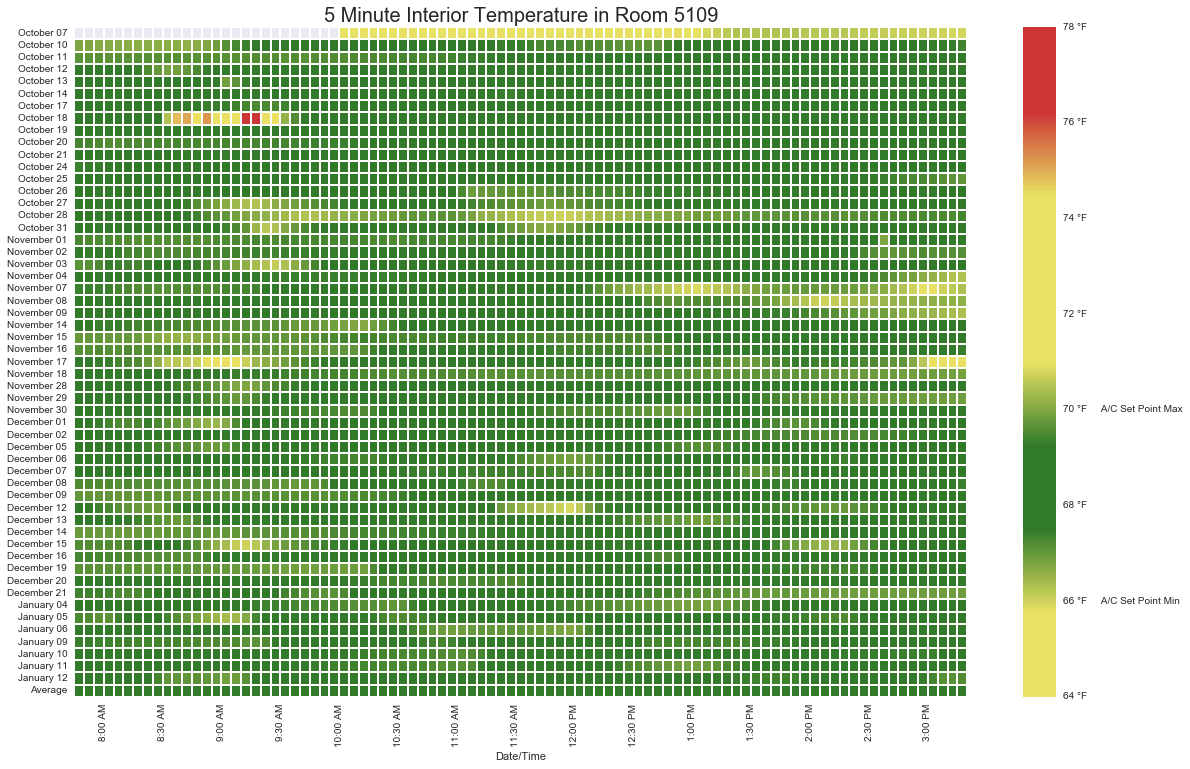

In [128]:
temp5109Fig = plt.figure(figsize = (20,12))
axes = newtemp5109Fig.add_axes([0,0,1,1])
axes = sns.heatmap(newtemp5109.dropna(thresh = 2).T, cmap = tempScale, linewidths = 1
                   , cbar = False, vmin = 64, vmax = 78)

# Set x tick marks to fall at the start at every hour and 30 minute marks

plt.xticks([3, 9, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 81, 87],
           ["8:00 AM", "8:30 AM", "9:00 AM", "9:30 AM", "10:00 AM", "10:30 AM", "11:00 AM", "11:30 AM", "12:00 PM",
            "12:30 PM" ,"1:00 PM", "1:30 PM", "2:00 PM", "2:30 PM", "3:00 PM"])

cbar = axes.figure.colorbar(axes.collections[0], )

# Set tick marks on color bar

cbar.set_ticks([64, 66, 68, 70, 72, 74, 76, 78, 80])
cbar.set_ticklabels(["64 °F", "66 °F     A/C Set Point Min", "68 °F", "70 °F     A/C Set Point Max", "72 °F", 
                     "74 °F", "76 °F", "78 °F", "80 °F"])

axes.set_title("5 Minute Interior Temperature in Room 5109", fontdict = {"fontsize": 20})

In [129]:
# os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualization Prep/Visualizations/Heat Maps")
# temp5210Fig.savefig("5210 Temp Heat Map.pdf", bbox_inches = "tight")
# temp5216Fig.savefig("5216 Temp Heat Map.pdf", bbox_inches = "tight")
# temp5218Fig.savefig("5218 Temp Heat Map.pdf", bbox_inches = "tight")

# temp5305Fig.savefig("5305 Temp Heat Map.pdf", bbox_inches = "tight")
# temp5308Fig.savefig("5308 Temp Heat Map.pdf", bbox_inches = "tight")
# temp5402Fig.savefig("5402 Temp Heat Map.pdf", bbox_inches = "tight")

# temp5B09Fig.savefig("5B09 Temp Heat Map.pdf", bbox_inches = "tight")
# temp5114Fig.savefig("5114 Temp Heat Map.pdf", bbox_inches = "tight")
# temp5109Fig.savefig("5109 Temp Heat Map.pdf", bbox_inches = "tight")

## CO2 Heat Maps

In [56]:
# Create color map scales for Air Quality Heat maps
airScale = LinearSegmentedColormap.from_list('mycmap', ['#317a2a','#317a2a', '#317a2a', '#317a2a', '#e8e163', '#e8e163','#e8e163', "#e8e163", "#e8e163", "#cc3535", '#cc3535'])

In [57]:
# air5210 = multiPlot(start, end, "5210", "CO2")
# air5216 = multiPlot(start, end, "5216", "CO2")
# air5218 = multiPlot(start, end, "5218", "CO2")

# air5305 = multiPlot(start, end, "5305", "CO2")
# air5308 = multiPlot(start, end, "5308", "CO2")
# air5402 = multiPlot(start, end, "5402", "CO2")

# air5B09 = multiPlot(start, end, "5B09", "CO2")
# air5114 = multiPlot(start, end, "5114", "CO2")
# air5109 = multiPlot(start, end, "5109", "CO2")

In [75]:
# air5210["Average"] = np.mean(air5210[["October 07", "October 10", "October 11", "October 12"]], axis = 1)
# air5216["Average"] = np.mean(air5216[['October 11', 'December 16', 'January 11', 'January 12']], axis = 1)
# air5308["Average"] = np.mean(air5308[['November 14', 'November 15', 'November 28', 'November 29', 'November 30']], axis = 1)

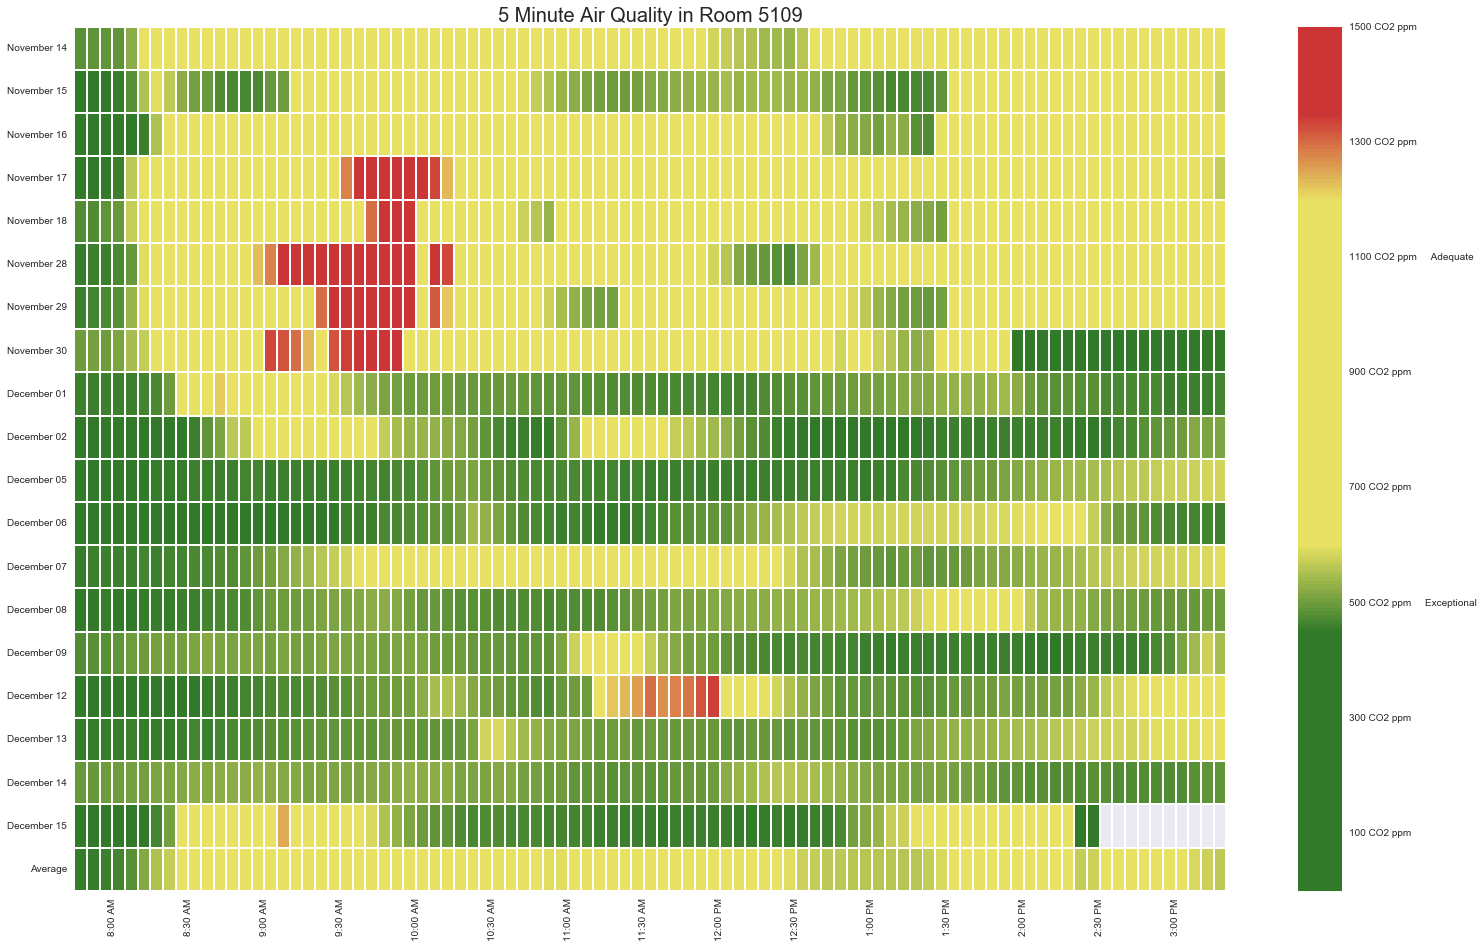

In [81]:
air5109Fig = plt.figure(figsize = (20,12))
axes = air5109Fig.add_axes([0,0,1,1])
axes = sns.heatmap(air5109.dropna(thresh = 2).T, cmap = airScale, linewidths = 1
                   , cbar = False, vmin = 0, vmax = 1500)

# Set x tick marks to fall at the start at every hour and 30 minute marks

plt.xticks([3, 9, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 81, 87],
           ["8:00 AM", "8:30 AM", "9:00 AM", "9:30 AM", "10:00 AM", "10:30 AM", "11:00 AM", "11:30 AM", "12:00 PM",
            "12:30 PM" ,"1:00 PM", "1:30 PM", "2:00 PM", "2:30 PM", "3:00 PM"])

# Set tick marks and labels for color bar

cbar = axes.figure.colorbar(axes.collections[0])
cbar.set_ticks([100, 300, 500, 700, 900, 1100, 1300, 1500])
cbar.set_ticklabels(["100 CO2 ppm", "300 CO2 ppm", "500 CO2 ppm     Exceptional", "700 CO2 ppm", "900 CO2 ppm",
                     "1100 CO2 ppm     Adequate", "1300 CO2 ppm", "1500 CO2 ppm"])

axes.set_title("5 Minute Air Quality in Room 5109", fontdict = {"fontsize": 20})

In [32]:
## Calculate the percentage of time co2 values fall within specified benchmarks

# for x in rooms:
#     bad = 0
#     ok = 0
#     good = 0
#     count = len(classTemp[(classTemp["Room"] == x) & 
#                           (classTemp["School Day"] == 0)]["CO2"].dropna())
    
#     for illum in classTemp[(classTemp["Room"] == x) & 
#                           (classTemp["School Day"] == 0)]["CO2"].dropna():
#         if illum > 1100:
#             bad+=1
#         elif illum >= 500 and illum < 1100:
#             ok+=1
#         elif illum < 500:
#             good+=1
#         else:
#             pass
    
#     print(x)
#     print(count)
#     print(" ")
#     print("Poor: ", bad/count)
#     print("Adequate: ", ok/count)
#     print("Exceptional: ", good/count)
#     print(" ")

In [82]:
# os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualization Prep/Visualizations/Heat Maps")
# air5210Fig.savefig("5210 CO2 Heat Map.pdf", bbox_inches = "tight")
# air5216Fig.savefig("5216 CO2 Heat Map.pdf", bbox_inches = "tight")
# air5218Fig.savefig("5218 CO2 Heat Map.pdf", bbox_inches = "tight")

# air5305Fig.savefig("5305 CO2 Heat Map.pdf", bbox_inches = "tight")
# air5308Fig.savefig("5308 CO2 Heat Map.pdf", bbox_inches = "tight")
# air5402Fig.savefig("5402 CO2 Heat Map.pdf", bbox_inches = "tight")

# air5B09Fig.savefig("5B09 CO2 Heat Map.pdf", bbox_inches = "tight")
# air5114Fig.savefig("5114 CO2 Heat Map.pdf", bbox_inches = "tight")
# air5109Fig.savefig("5109 CO2 Heat Map.pdf", bbox_inches = "tight")

### Decibels Heat Map

In [83]:
# sound5210 = multiPlot(start, end, "5210", "Decibels")
# sound5216 = multiPlot(start, end, "5216", "Decibels")
# sound5218 = multiPlot(start, end, "5218", "Decibels")

# sound5305 = multiPlot(start, end, "5305", "Decibels")
# sound5308 = multiPlot(start, end, "5308", "Decibels")
# sound5402 = multiPlot(start, end, "5402", "Decibels")

# sound5B09 = multiPlot(start, end, "5B09", "Decibels")
# sound5114 = multiPlot(start, end, "5114", "Decibels")
# sound5109 = multiPlot(start, end, "5109", "Decibels")

In [84]:
# Set the color map scales for decibel levels
soundScale = LinearSegmentedColormap.from_list('mycmap', ["#317a2a", '#317a2a', '#317a2a', "#e8e163", "#e8e163", "#e8e163", "#e8e163", "#cc3535", '#cc3535'])

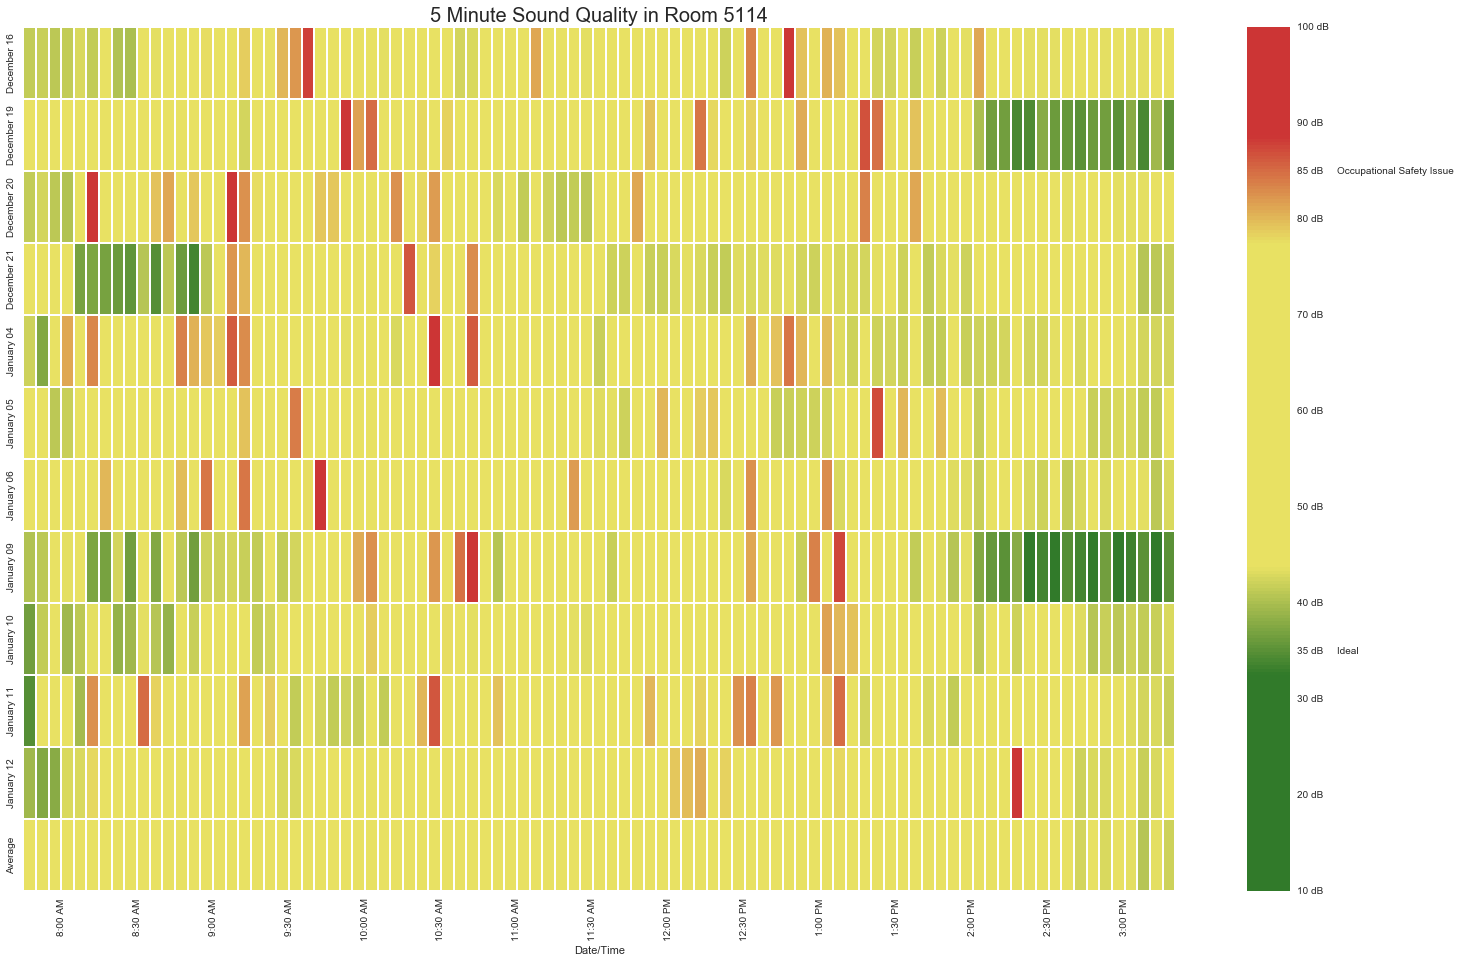

In [94]:
sound5114Fig = plt.figure(figsize = (20,12))
axes = sound5114Fig.add_axes([0,0,1,1])
axes = sns.heatmap(sound5114.dropna(thresh = 2).T, cmap = soundScale, linewidths = 1
                   , cbar = False, vmin = 10, vmax = 100)

# Set x tick marks to fall at the start at every hour and 30 minute marks

plt.xticks([3, 9, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 81, 87],
           ["8:00 AM", "8:30 AM", "9:00 AM", "9:30 AM", "10:00 AM", "10:30 AM", "11:00 AM", "11:30 AM", "12:00 PM",
            "12:30 PM" ,"1:00 PM", "1:30 PM", "2:00 PM", "2:30 PM", "3:00 PM"])

# Set tick marks for color bar

cbar = axes.figure.colorbar(axes.collections[0])
cbar.set_ticks([10, 20, 30, 35, 40, 50, 60, 70, 80, 85, 90, 100])
cbar.set_ticklabels(["10 dB","20 dB","30 dB", "35 dB     Ideal", "40 dB", "50 dB", "60 dB", 
                     "70 dB", "80 dB", "85 dB     Occupational Safety Issue", "90 dB", "100 dB"])

axes.set_title("5 Minute Sound Quality in Room 5114", fontdict = {"fontsize": 20})

In [95]:
# os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualization Prep/Visualizations/Heat Maps")
# sound5210Fig.savefig("5210 Sound Heat Map.pdf", bbox_inches = "tight")
# sound5216Fig.savefig("5216 Sound Heat Map.pdf", bbox_inches = "tight")
# sound5218Fig.savefig("5218 Sound Heat Map.pdf", bbox_inches = "tight")

# sound5305Fig.savefig("5305 Sound Heat Map.pdf", bbox_inches = "tight")
# sound5308Fig.savefig("5308 Sound Heat Map.pdf", bbox_inches = "tight")
# sound5402Fig.savefig("5402 Sound Heat Map.pdf", bbox_inches = "tight")

# sound5B09Fig.savefig("5B09 Sound Heat Map.pdf", bbox_inches = "tight")
# sound5114Fig.savefig("5114 Sound Heat Map.pdf", bbox_inches = "tight")
# sound5109Fig.savefig("5109 Sound Heat Map.pdf", bbox_inches = "tight")

### Light Levels Heat Map

In [96]:
# illum5210 = multiPlot(start, end, "5210", "Illum")
# illum5216 = multiPlot(start, end, "5216", "Illum")
# illum5218 = multiPlot(start, end, "5218", "Illum")

# illum5305 = multiPlot(start, end, "5305", "Illum")
# illum5308 = multiPlot(start, end, "5308", "Illum")
# illum5402 = multiPlot(start, end, "5402", "Illum")

# illum5B09 = multiPlot(start, end, "5B09", "Illum")
# illum5114 = multiPlot(start, end, "5114", "Illum")
# illum5109 = multiPlot(start, end, "5109", "Illum")

In [97]:
# Set color map scales for lighting quality
illumScale = LinearSegmentedColormap.from_list('mycmap', ['#cc3535', '#cc3535', '#317a2a', '#317a2a', '#317a2a', '#317a2a', "#e8e163", "#e8e163", "#e8e163", "#e8e163", "#e8e163"])

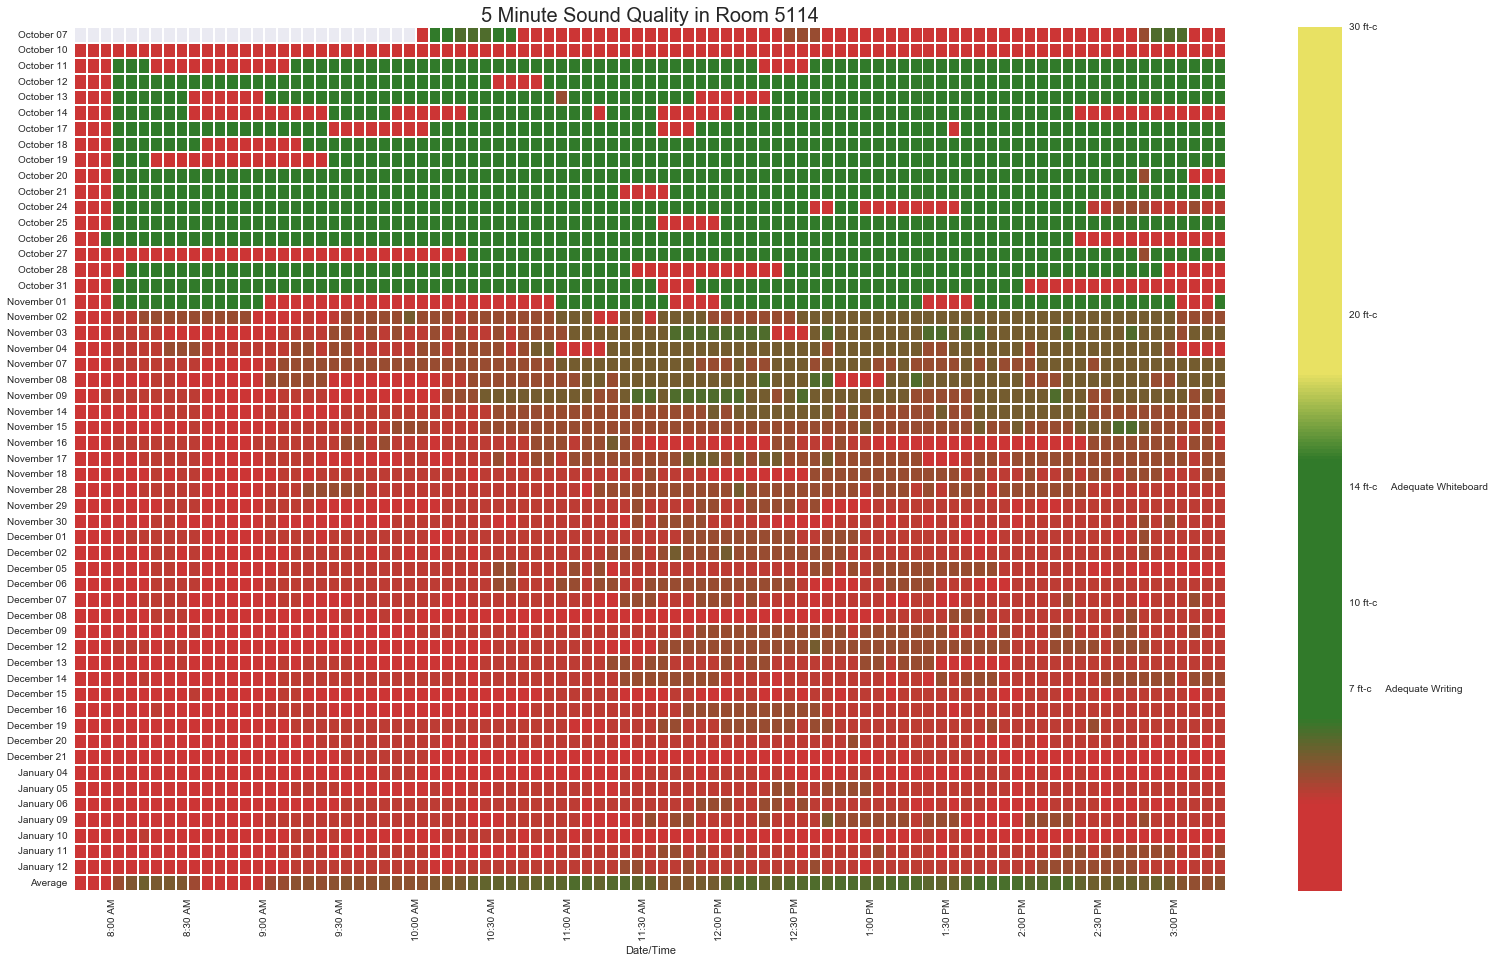

In [109]:
illum5114Fig = plt.figure(figsize = (20,12))
axes = illum5114Fig.add_axes([0,0,1,1])
axes = sns.heatmap(illum5114.dropna(thresh = 2).T, cmap = illumScale, linewidths = 1
                   , cbar = False, vmin = 0, vmax = 30)

plt.xticks([3, 9, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 81, 87],
           ["8:00 AM", "8:30 AM", "9:00 AM", "9:30 AM", "10:00 AM", "10:30 AM", "11:00 AM", "11:30 AM", "12:00 PM",
            "12:30 PM" ,"1:00 PM", "1:30 PM", "2:00 PM", "2:30 PM", "3:00 PM"])

cbar = axes.figure.colorbar(axes.collections[0])
cbar.set_ticks([7, 10, 14, 20, 30, 40])
cbar.set_ticklabels(["7 ft-c     Adequate Writing", "10 ft-c", "14 ft-c     Adequate Whiteboard",
                     "20 ft-c","30 ft-c", "40 ft-c"])

axes.set_title("5 Minute Sound Quality in Room 5114", fontdict = {"fontsize": 20})

In [101]:
## Calcualte the percentage of time spent within specified benchmarks 

# for x in rooms:
#     bad = 0
#     ok = 0
#     good = 0
#     count = len(classTemp[(classTemp["Room"] == x) & 
#                           (classTemp["School Day"] == 0)]["Illum"].dropna())
    
#     for illum in classTemp[(classTemp["Room"] == x) & 
#                           (classTemp["School Day"] == 0)]["Illum"].dropna():
#         if illum < 7:
#             bad+=1
#         elif illum >= 7 and illum < 14:
#             ok+=1
#         elif illum >= 14:
#             good+=1
#         else:
#             pass
    
#     print(x)
#     print(count)
#     print(" ")
#     print("Inadequate: ", bad/count)
#     print("Ok for Writing: ", ok/count)
#     print("Ok for Whiteboard: ", good/count)
#     print(" ")

In [110]:
# os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualization Prep/Visualizations/Heat Maps")
# illum5210Fig.savefig("5210 Light Heat Map.pdf", bbox_inches = "tight")
# illum5216Fig.savefig("5216 Light Heat Map.pdf", bbox_inches = "tight")
# illum5218Fig.savefig("5218 Light Heat Map.pdf", bbox_inches = "tight")

# illum5305Fig.savefig("5305 Light Heat Map.pdf", bbox_inches = "tight")
# illum5308Fig.savefig("5308 Light Heat Map.pdf", bbox_inches = "tight")
# illum5402Fig.savefig("5402 Light Heat Map.pdf", bbox_inches = "tight")

# illum5B09Fig.savefig("5B09 Light Heat Map.pdf", bbox_inches = "tight")
# illum5114Fig.savefig("5114 Light Heat Map.pdf", bbox_inches = "tight")
# illum5109Fig.savefig("5109 Light Heat Map.pdf", bbox_inches = "tight")

### Thermal Comfort Heat Map

In [111]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualization Prep/Raw Files/Raw PMV Data All Days")
pmvData = pd.read_excel("Full Raw All Days PMV Data.xlsx", index_col = 0)
timeValues(pmvData)
daysoff(pmvData)
pmvData = pmvData[pmvData["School Day"] == 1]

In [112]:
# Function to create data frames with columns of days, rows of the day in 5 minute incriments and PMV values

def multiPMV(start, end, room):

    delta = end - start
    
    dateList = []
    for i in range(delta.days + 1):
        hold = (start + datetime.timedelta(days=i))
        hold = datetime.datetime.strftime(hold, "%Y-%m-%d")
        dateList.append(hold)

    holder = pd.DataFrame()

    num = 0
    for date in dateList:
        
        dateHold = datetime.datetime.strptime(date, "%Y-%m-%d").date()
        dateHold = datetime.datetime.strftime(dateHold, "%B %d")
        
        try:
            df = pmvData.ix[date][room].dropna()

#             index =  df[room].dropna().reset_index()["Date/Time"].apply(lambda x: x.time()).unique().tolist()
            index = df.reset_index()['Date/Time'].apply(lambda x: x.time())

            rawData = df.tolist()

            newDF = pd.DataFrame(data = rawData, index = index)

            newDF.columns = [str(dateHold)]

            holder = pd.concat([holder, newDF],axis = 1)
        
        except:
#             print(dateHold)
            pass
        
    holder.dropna(axis = 1, thresh = 25, inplace = True)
    
    holder["Average"] = np.mean(holder,axis = 1)
    
    return(holder)

In [113]:
# For whatever reason the multiPMV would collect all days from 10/7 to 1/12/17 so I created this function to run the
# multiPMV for 2 periods of time then merged the two data sets

def pmvMerge(room):
    pmv1 = multiPMV(date(2016, 10, 7), date(2016, 12, 14), room)
    pmv2 = multiPMV(date(2016, 12, 15), date(2017, 1, 12), room)

    pmv1.drop("Average", axis = 1, inplace = True)
    pmv2.drop("Average", axis = 1, inplace = True)

    holder = pmv1.join(pmv2, how = "outer")
    
    holder["Average"] = np.mean(holder, axis = 1)
    
    return(holder)

In [114]:
# pmv5210 = pmvMerge("5210")
# pmv5216 = pmvMerge("5216")
# pmv5218 = pmvMerge("5218")

# pmv5305 = pmvMerge("5305")
# pmv5308 = pmvMerge("5308")
# pmv5402 = pmvMerge("5402")

# pmv5B09 = pmvMerge("5B09")
# pmv5114 = pmvMerge("5114")
# pmv5109 = pmvMerge("5109")

In [115]:
# Creating color map scales for PMV
pmvScale = LinearSegmentedColormap.from_list('mycmap', ['#cc3535', "#cc3535", "#e8e163", "#e8e163", '#317a2a', "#e8e163", "#e8e163", "#cc3535", '#cc3535'])

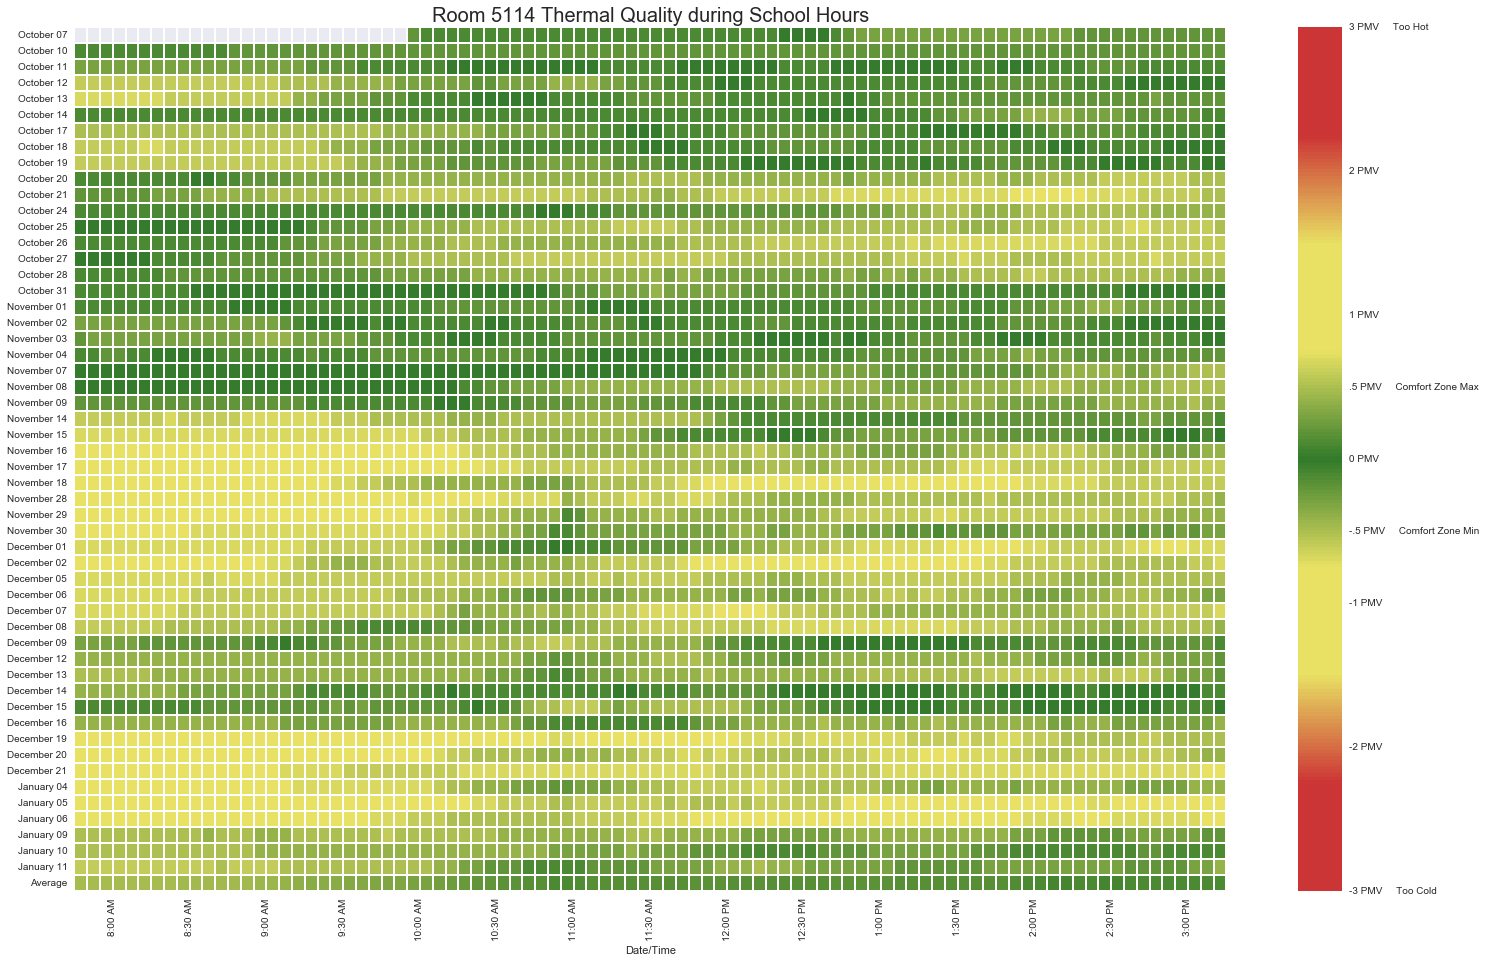

In [126]:
pmv5114Fig = plt.figure(figsize = (20,12))
axes = pmv5114Fig.add_axes([0,0,1,1])
axes = sns.heatmap(pmv5114.ix[datetime.time(7, 45):datetime.time(15, 15)].drop_duplicates().T, cmap = pmvScale, linewidths = 1
                   , cbar = False, vmin = -3, vmax = 3)

# Set x tick marks to fall at the start at every hour and 30 minute marks

plt.xticks([3, 9, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 81, 87],
           ["8:00 AM", "8:30 AM", "9:00 AM", "9:30 AM", "10:00 AM", "10:30 AM", "11:00 AM", "11:30 AM", "12:00 PM",
            "12:30 PM" ,"1:00 PM", "1:30 PM", "2:00 PM", "2:30 PM", "3:00 PM"])

# Setting tick marks and labels for color bar

cbar = axes.figure.colorbar(axes.collections[0])
cbar.set_ticks([-3, -2, -1, -.5, 0, .5, 1, 2, 3])
cbar.set_ticklabels(["-3 PMV     Too Cold", "-2 PMV", "-1 PMV", "-.5 PMV     Comfort Zone Min"
                     , "0 PMV", ".5 PMV     Comfort Zone Max", "1 PMV", "2 PMV", "3 PMV     Too Hot"])

axes.set_title("Room 5114 Thermal Quality during School Hours", fontdict = {"fontsize": 20})

In [127]:
# os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualization Prep/Visualizations/Heat Maps")
# pmv5210Fig.savefig("5210 PMV Heat Map.pdf", bbox_inches = "tight")
# pmv5216Fig.savefig("5216 PMV Heat Map.pdf", bbox_inches = "tight")
# pmv5218Fig.savefig("5218 PMV Heat Map.pdf", bbox_inches = "tight")
# pmv5305Fig.savefig("5305 PMV Heat Map.pdf", bbox_inches = "tight")
# pmv5308Fig.savefig("5308 PMV Heat Map.pdf", bbox_inches = "tight")
# pmv5402Fig.savefig("5402 PMV Heat Map.pdf", bbox_inches = "tight")
# pmv5B09Fig.savefig("5B09 PMV Heat Map.pdf", bbox_inches = "tight")
# pmv5114Fig.savefig("5114 PMV Heat Map.pdf", bbox_inches = "tight")
# pmv5109Fig.savefig("5109 PMV Heat Map.pdf", bbox_inches = "tight")

## Stats and Findings

In [684]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualizations/Python Visualization Prep/Files for Tableau")

tempAverage = pd.read_excel("Average Room Temp by Hour.xlsx", index_col = 0)
rhAverage = pd.read_excel("Average Room Relative Humidityw by Hour.xlsx", index_col = 0)
CO2Average = pd.read_excel("Average Room CO2 Level by Hour.xlsx", index_col = 0)
soundAverage = pd.read_excel("Average Room Decibel Level by Hour.xlsx", index_col = 0)
illumAverage = pd.read_excel("Average Room Illuminance Level by Hour.xlsx", index_col = 0)

### Temperature Stats

#### % of Time above and below thresholds during School Hours

In [1037]:
# Calculating the percentage of time above and below thersholds during school days and school hours, only with the
# Averages however, not that great of a fucntion, solved better with a for loop

print("5210: ", temp5210[temp5210 > 70]["Average"].count() / len(temp5210["Average"].dropna())) 
print("5216: ", temp5216[temp5216 > 70]["Average"].count() / len(temp5216["Average"].dropna())) 
print("5218: ", temp5218[temp5218 > 70]["Average"].count() / len(temp5218["Average"].dropna())) 
print("")
print("5305: ", temp5305[temp5305 > 70]["Average"].count() / len(temp5305["Average"].dropna())) 
print("5308: ", temp5308[temp5308 > 70]["Average"].count() / len(temp5308["Average"].dropna())) 
print("5402: ", temp5402[temp5402 > 70]["Average"].count() / len(temp5402["Average"].dropna())) 
print("")
print("5B09: ", temp5B09[temp5B09 > 70]["Average"].count() / len(temp5B09["Average"].dropna()))
print("5114: ", temp5114[temp5114 > 70]["Average"].count() / len(temp5114["Average"].dropna()))
print("5109: ", newtemp5109[newtemp5109 > 70]["Average"].count() / len(newtemp5109["Average"].dropna()))

5210:  0.813186813187
5216:  1.0
5218:  1.0

5305:  0.0
5308:  0.10989010989
5402:  0.813186813187

5B09:  0.0
5114:  0.67032967033
5109:  0.0


In [1038]:
# Calculating the percentage of time above and below thersholds during school days and school hours, only with the
# Averages however, not that great of a fucntion, solved better with a for loop

print("5210: ", temp5210[temp5210 < 66]["Average"].count() / len(temp5210["Average"].dropna())) 
print("5216: ", temp5216[temp5216 < 66]["Average"].count() / len(temp5216["Average"].dropna())) 
print("5218: ", temp5218[temp5218 < 66]["Average"].count() / len(temp5218["Average"].dropna())) 
print("")
print("5305: ", temp5305[temp5305 < 66]["Average"].count() / len(temp5305["Average"].dropna())) 
print("5308: ", temp5308[temp5308 < 66]["Average"].count() / len(temp5308["Average"].dropna())) 
print("5402: ", temp5402[temp5402 < 66]["Average"].count() / len(temp5402["Average"].dropna())) 
print("")
print("5B09: ", temp5B09[temp5B09 < 66]["Average"].count() / len(temp5B09["Average"].dropna()))
print("5114: ", temp5114[temp5114 < 66]["Average"].count() / len(temp5114["Average"].dropna()))
print("5109: ", newtemp5109[newtemp5109 < 66]["Average"].count() / len(newtemp5109["Average"].dropna()))

5210:  0.0
5216:  0.0
5218:  0.0

5305:  0.0
5308:  0.0
5402:  0.0

5B09:  0.307692307692
5114:  0.0
5109:  0.0


#### Averages During School Hours

In [714]:
print("5210: ", np.mean(temp5210["Average"]))
print("5216: ", np.mean(temp5216["Average"]))
print("5218: ", np.mean(temp5218["Average"]))
print(" ")
print("5305: ", np.mean(temp5305["Average"]))
print("5308: ", np.mean(temp5308["Average"]))
print("5402: ", np.mean(temp5402["Average"]))
print(" ")
print("5B09: ", np.mean(temp5B09["Average"]))
print("5114: ", np.mean(temp5114["Average"]))
print("5109: ", np.mean(newtemp5109["Average"]))

5210:  71.3021233296
5216:  72.9759639435
5218:  73.5948850224
 
5305:  67.8455368873
5308:  69.335246805
5402:  71.0119444324
 
5B09:  67.1757574969
5114:  70.3040804939
5109:  68.4986159529


#### Outside of School Hours

#### Less Than Set Point

In [1034]:
# Calculating the percentage of time air temperature was below the AC set point during time outside of school hours,
# on school days and non school days. Howeever this is missing school hours on weekends and such

for x in ['5210', '5402', '5216', '5305', '5218', '5308', '5B09', '5114']:
    print(x + ": ",(classTemp[(classTemp["Room"] == x) & 
             (classTemp["School Hour"] == 0) &
                    (classTemp["Temp"] < 66)]["Temp"].count()) / len(classTemp[(classTemp["Room"] == x) & 
                                                                      (classTemp["School Hour"] == 0)]["Temp"].dropna()))

5210:  0.269592226824
5402:  0.0332900484004
5216:  0.0
5305:  0.345926738778
5218:  0.000310784212162
5308:  0.259038640837
5B09:  0.486126352093
5114:  0.3159847416


In [1032]:
# Calculating the percentage of time air temperature was below the AC set point during time outside of school hours,
# on school days and non school days. Howeever this is missing school hours on weekends and such

temp5109[(temp5109["School Hour"] == 0) & (temp5109["Temp"] < 66)]["Temp"].count() / len(temp5109[temp5109["School Hour"] == 0]["Temp"].dropna())

0.00011244167088322933

#### Greater Than Set Point

In [1035]:
# Calculating the percentage of time air temperature was above the AC set point during time outside of school hours,
# on school days and non school days. Howeever this is missing school hours on weekends and such

for x in ['5210', '5402', '5216', '5305', '5218', '5308', '5B09', '5114']:
    print(x + ": ",(classTemp[(classTemp["Room"] == x) & 
             (classTemp["School Hour"] == 0) &
                    (classTemp["Temp"] > 70)]["Temp"].count()) / len(classTemp[(classTemp["Room"] == x) & 
                                                                      (classTemp["School Hour"] == 0)]["Temp"].dropna()))

5210:  0.404069767442
5402:  0.614803447055
5216:  0.848803480783
5305:  0.162930448869
5218:  0.839376359681
5308:  0.286957422563
5B09:  0.110518890108
5114:  0.311229555312


In [1036]:
# Calculating the percentage of time air temperature was above the AC set point during time outside of school hours,
# on school days and non school days. Howeever this is missing school hours on weekends and such

temp5109[(temp5109["School Hour"] == 0) & (temp5109["Temp"] > 70)]["Temp"].count() / len(temp5109[temp5109["School Hour"] == 0]["Temp"].dropna())

0.058239163433968628

In [1077]:
# Creating data frame of average daily profile of temperature in room 5109
test = classTemp[(classTemp["Room"] == "5109") & (classTemp["School Day"] == 1)].reset_index()
test["Time"] = test["Date/Time"].apply(lambda x: x.time())
test = test.groupby("Time")["Temp"].mean()
test = pd.DataFrame(test)

In [1085]:
test = temp5109[(temp5109["Room"] == "5109") & (temp5109["School Day"] == 1)].reset_index()
test["Time"] = test["Date/Time"].apply(lambda x: x.time())
test = test.groupby("Time")["Temp"].mean()
test = pd.DataFrame(test)

#### Variance

In [728]:
np.var(pd.concat([
        temp5210["Average"],
        temp5218["Average"],
        temp5216["Average"],
        temp5305["Average"],
        temp5308["Average"],
        temp5402["Average"],
        temp5B09["Average"],
        temp5114["Average"],
        newtemp5109["Average"]
          ], axis = 0))

5.4243210659142935

In [1178]:
averageTemp = pd.concat([
        temp5210["Average"],
        temp5218["Average"],
        temp5216["Average"],
        temp5305["Average"],
        temp5308["Average"],
        temp5402["Average"],
        temp5B09["Average"],
        temp5114["Average"],
        newtemp5109["Average"]
          ], axis = 1)

averageTemp.columns = ["5210", "5218", "5216", "5305", "5308", "5402", "5B09", "5114", "5109"]

averageTemp["Average"] = np.mean(averageTemp, axis = 1)

### Decibel Stats

#### Time in thresholds during school hours

In [973]:
# Calculating the percentage of time sound quality was below an average whisper during school hours and school days
# However is only for average daily profiles not the raw data. This could be done beter with for loop

print("5210: ", sound5210[sound5210 <= 30]["Average"].count() / len(sound5210["Average"].dropna()))
print("5216: ", sound5216[sound5216 <= 30]["Average"].count() / len(sound5216["Average"].dropna()))
print("5218: ", sound5218[sound5218 <= 30]["Average"].count() / len(sound5218["Average"].dropna()))
print(" ")
print("5305: ", sound5305[sound5305 <= 30]["Average"].count() / len(sound5305["Average"].dropna()))
print("5308: ", sound5308[sound5308 <= 30]["Average"].count() / len(sound5308["Average"].dropna()))
print("5402: ", sound5402[sound5402 <= 30]["Average"].count() / len(sound5402["Average"].dropna()))
print(" ")
print("5B09: ", sound5B09[sound5B09 <= 30]["Average"].count() / len(sound5B09["Average"].dropna()))
print("5109: ", sound5109[sound5109 <= 30]["Average"].count() / len(sound5109["Average"].dropna()))
print("5114: ", sound5114[sound5114 <= 30]["Average"].count() / len(sound5114["Average"].dropna()))

5210:  0.021978021978
5216:  0.0
5218:  0.0
 
5305:  0.0
5308:  0.0
5402:  0.0
 
5B09:  0.021978021978
5109:  0.0
5114:  0.0


In [22]:
# Calculating the percentage of time sound quality was at a conversational level during school hours and school days
# However is only for average daily profiles not the raw data. This could be done beter with for loop

print("5210: ", sound5210[(sound5210 >= 35) & (sound5210 <= 40)]["Average"].count() / len(sound5210["Average"].dropna()))
print("5216: ", sound5216[(sound5216 >= 35) & (sound5216 <= 40)]["Average"].count() / len(sound5216["Average"].dropna()))
print("5218: ", sound5218[(sound5218 >= 35) & (sound5218 <= 40)]["Average"].count() / len(sound5218["Average"].dropna()))
print(" ")
print("5305: ", sound5305[(sound5305 >= 35) & (sound5305 <= 40)]["Average"].count() / len(sound5305["Average"].dropna()))
print("5308: ", sound5308[(sound5308 >= 35) & (sound5308 <= 40)]["Average"].count() / len(sound5308["Average"].dropna()))
print("5402: ", sound5402[(sound5402 >= 35) & (sound5402 <= 40)]["Average"].count() / len(sound5402["Average"].dropna()))
print(" ")
print("5B09: ", sound5B09[(sound5B09 >= 35) & (sound5B09 <= 40)]["Average"].count() / len(sound5B09["Average"].dropna()))
print("5109: ", sound5109[(sound5109 >= 35) & (sound5109 <= 40)]["Average"].count() / len(sound5109["Average"].dropna()))
print("5114: ", sound5114[(sound5114 >= 35) & (sound5114 <= 40)]["Average"].count() / len(sound5114["Average"].dropna()))

5210:  0.120879120879
5216:  0.0
5218:  0.0
 
5305:  0.0
5308:  0.0
5402:  0.0
 
5B09:  0.131868131868
5109:  0.043956043956
5114:  0.0


In [971]:
# Calculating the percentage of time sound quality was at average vacuum levels during school hours and school days
# However is only for average daily profiles not the raw data. This could be done beter with for loop

print("5210: ", sound5210[(sound5210 >= 60) & (sound5210 < 90)]["Average"].count() / len(sound5210["Average"].dropna()))
print("5216: ", sound5216[(sound5216 >= 60) & (sound5216 < 90)]["Average"].count() / len(sound5216["Average"].dropna()))
print("5218: ", sound5218[(sound5218 >= 60) & (sound5218 < 90)]["Average"].count() / len(sound5218["Average"].dropna()))
print(" ")
print("5305: ", sound5305[(sound5305 >= 60) & (sound5305 < 90)]["Average"].count() / len(sound5305["Average"].dropna()))
print("5308: ", sound5308[(sound5308 >= 60) & (sound5308 < 90)]["Average"].count() / len(sound5308["Average"].dropna()))
print("5402: ", sound5402[(sound5402 >= 60) & (sound5402 < 90)]["Average"].count() / len(sound5402["Average"].dropna()))
print(" ")
print("5B09: ", sound5B09[(sound5B09 >= 60) & (sound5B09 < 90)]["Average"].count() / len(sound5B09["Average"].dropna()))
print("5109: ", sound5109[(sound5109 >= 60) & (sound5109 < 90)]["Average"].count() / len(sound5109["Average"].dropna()))
print("5114: ", sound5114[(sound5114 >= 60) & (sound5114 < 90)]["Average"].count() / len(sound5114["Average"].dropna()))

5210:  0.197802197802
5216:  0.307692307692
5218:  0.186813186813
 
5305:  0.703296703297
5308:  0.516483516484
5402:  0.307692307692
 
5B09:  0.21978021978
5109:  0.0
5114:  0.549450549451


In [970]:
# Calculating the percentage of time sound quality was at extremely high levels during school hours and school days
# However is only for average daily profiles not the raw data. This could be done beter with for loop

print("5210: ", sound5210[sound5210 >= 90]["Average"].count() / len(sound5210["Average"].dropna()))
print("5216: ", sound5216[sound5216 >= 90]["Average"].count() / len(sound5216["Average"].dropna()))
print("5218: ", sound5218[sound5218 >= 90]["Average"].count() / len(sound5218["Average"].dropna()))
print(" ")
print("5305: ", sound5305[sound5305 >= 90]["Average"].count() / len(sound5305["Average"].dropna()))
print("5308: ", sound5308[sound5308 >= 90]["Average"].count() / len(sound5308["Average"].dropna()))
print("5402: ", sound5402[sound5402 >= 90]["Average"].count() / len(sound5402["Average"].dropna()))
print(" ")
print("5B09: ", sound5B09[sound5B09 >= 90]["Average"].count() / len(sound5B09["Average"].dropna()))
print("5109: ", sound5109[sound5109 >= 90]["Average"].count() / len(sound5109["Average"].dropna()))
print("5114: ", sound5114[sound5114 >= 90]["Average"].count() / len(sound5114["Average"].dropna()))

5210:  0.0
5216:  0.0
5218:  0.0
 
5305:  0.0
5308:  0.0
5402:  0.0
 
5B09:  0.0
5109:  0.0
5114:  0.0


In [822]:
np.var(pd.concat([
        sound5210["Average"],
        sound5218["Average"],
        sound5216["Average"],
        sound5305["Average"],
        sound5308["Average"],
        sound5402["Average"],
        sound5B09["Average"],
        sound5114["Average"],
        sound5109["Average"]
          ], axis = 0))

91.385420355334503

In [1193]:
averageSound = pd.concat([
        sound5210["Average"],
        sound5218["Average"],
        sound5216["Average"],
        sound5305["Average"],
        sound5308["Average"],
        sound5402["Average"],
        sound5B09["Average"],
        sound5114["Average"],
        sound5109["Average"]],
          axis = 1)

averageSound.columns = ["5210", "5218", "5216", "5305", "5308", "5402", "5B09", "5114", "5109"]

averageSound["Average"] = np.mean(averageSound, axis = 1)
averageSound.dropna(axis = 0, inplace = True)

In [31]:
# Calculating the percentage of time sound quality falls within specified thresholds outside of school hours, however
# this is also removing school hours on the weekend

for x in rooms:
    holder = classTemp[(classTemp["Room"] == x) & 
                       (classTemp["School Day"] == 0) & 
                       (classTemp["School Hour"] == 0)]["Decibels"].dropna()
    count = holder.count()
    ideal = 0
    adequate = 0
    loud = 0
    for y in holder:
        if y <= 40:
            ideal += 1
        elif y > 40 and y <= 85:
            adequate += 1
        elif y > 85:
            loud += 1
        else:
            pass
    
    print(x)
    print("ideal", (ideal/count))
    print("adequate", (adequate/count))
    print("loud", (loud/count))

5210
ideal 0.935479561849
adequate 0.0645204381512
loud 0.0
5402
ideal 0.0
adequate 1.0
loud 0.0
5216
ideal 0.00358315915199
adequate 0.996416840848
loud 0.0
5305
ideal 0.946275946276
adequate 0.0537240537241
loud 0.0
5218
ideal 0.0
adequate 1.0
loud 0.0
5308
ideal 0.000720980533526
adequate 0.999279019466
loud 0.0
5B09
ideal 0.968274111675
adequate 0.0317258883249
loud 0.0
5114
ideal 0.692744102717
adequate 0.307255897283
loud 0.0
5109
ideal 0.916243654822
adequate 0.0837563451777
loud 0.0


#### Time in thresholds outside of school hours

#### Less than 30

In [816]:
for x in rooms:
    print(x + ": ", (classTemp[(classTemp["School Hour"] == 0) & 
          (classTemp["Room"] == x) & 
           (classTemp["Decibels"] < 30)]["Decibels"].count()) / (len(classTemp[(classTemp["School Hour"] == 0) & 
          (classTemp["Room"] == x)]["Decibels"].dropna())))

5210:  0.0926026546612
5402:  0.0
5216:  0.0
5305:  0.00763553066938
5218:  0.0
5308:  0.0
5B09:  0.402244134648
5114:  0.00471356055112
5109:  0.00135501355014


#### Between 30 and 60

In [818]:
for x in rooms:
    print(x + ": ", (classTemp[(classTemp["School Hour"] == 0) & 
          (classTemp["Room"] == x) & 
           (classTemp["Decibels"] >= 30) &
            (classTemp["Decibels"] < 60)]["Decibels"].count()) / (len(classTemp[(classTemp["School Hour"] == 0) & 
          (classTemp["Room"] == x)]["Decibels"].dropna())))

5210:  0.88737095397
5402:  0.97371107708
5216:  0.987218721872
5305:  0.986765080173
5218:  0.9945737791
5308:  0.987352445194
5B09:  0.55831349881
5114:  0.990210297317
5109:  0.963414634146


#### Between 60 and 90

In [819]:
for x in rooms:
    print(x + ": ", (classTemp[(classTemp["School Hour"] == 0) & 
              (classTemp["Room"] == x) & 
               (classTemp["Decibels"] >= 60) &
                (classTemp["Decibels"] < 90)]["Decibels"].count()) / (len(classTemp[(classTemp["School Hour"] == 0) & 
          (classTemp["Room"] == x)]["Decibels"].dropna())))

5210:  0.0199487696965
5402:  0.0262889229199
5216:  0.0127812781278
5305:  0.00559938915755
5218:  0.0054262208997
5308:  0.0122259696459
5B09:  0.0391023461408
5114:  0.00507614213198
5109:  0.034891598916


#### Greater than 90

In [820]:
for x in rooms:
    print(x + ": ", (classTemp[(classTemp["School Hour"] == 0) & 
          (classTemp["Room"] == x) & 
           (classTemp["Decibels"] > 90)]["Decibels"].count()) / (len(classTemp[(classTemp["School Hour"] == 0) & 
          (classTemp["Room"] == x)]["Decibels"].dropna())))

5210:  7.76216719708e-05
5402:  0.0
5216:  0.0
5305:  0.0
5218:  0.0
5308:  0.000421585160202
5B09:  0.000340020401224
5114:  0.0
5109:  0.000338753387534


In [1170]:
test = classTemp[(classTemp["Room"] == "5B09") & (classTemp["School Day"] == 1)].reset_index()
test["Time"] = test["Date/Time"].apply(lambda x: x.time())
test = test.groupby("Time")["Decibels"].mean()
test = pd.DataFrame(test)

### Air Quality Stats

#### Above or below benchmarks during school hours

#### Exceptional Level

In [919]:
#Room 5216 only has 3 days worth of quality data
air5216 = multiPlot(date(2016,12,15), date(2017,1,13),"5216", "CO2")
air5216.drop(['December 19', 'December 20', 'December 21','January 04', 
              'January 05', 'January 06', 'January 09', 'January 10', "January 13"], axis = 1, inplace = True)
air5216["Average"] = np.mean(air5216[["December 16", "January 11", "January 12"]], axis = 1)

In [940]:
#Room 5308 only has 4 Days of quality data
air5308.drop(["November 15", "November 16", "November 17", "November 18"], axis = 1, inplace = True)
air5308["Average"] = np.mean(air5308[['November 14', 'November 28', 'November 29', 'November 30']], axis = 1)

In [ ]:
#Room 5114 has a couple days of bad data
air5114.drop(["November 15", "November 16", "November 17", "November 18"], axis = 1, inplace = True)
air5114["Average"] = np.mean(air5114[['November 14', 'November 28', 'November 29', 'November 30',
       'December 01', 'December 02', 'December 05', 'December 06',
       'December 07', 'December 08', 'December 09', 'December 12',
       'December 13', 'December 14', 'December 15']], axis = 1)

In [1105]:
#Room 5210 only has a couple days of quality data
air5210.drop(['October 12', 'October 13',
       'October 14', 'October 17', 'October 18', 'October 19', 'October 20',
       'October 21', 'October 24', 'October 25', 'October 26', 'October 27',
       'October 28', 'October 31', 'November 01', 'November 02', 'November 03',
       'November 04', 'November 07', 'November 08', 'November 09', 'Average'],axis = 1, inplace = True)

air5210["Average"] = np.mean(air5210[["October 07", "October 10", "October 11"]], axis = 1)

In [1112]:
air5402.dropna(inplace = True)

In [1113]:
print("5210: ", air5210[air5210["Average"] <= 500]["Average"].count() / len(air5210["Average"].dropna()))
print("5216: ", air5216[air5216["Average"] <= 500]["Average"].count() / len(air5216["Average"].dropna()))
print("5218: ", air5218[air5218["Average"] <= 500]["Average"].count() / len(air5218["Average"].dropna()))
print(" ")
print("5305: ", air5305[air5305["Average"] <= 500]["Average"].count() / len(air5305["Average"].dropna()))
print("5308: ", air5308[air5308["Average"] <= 500]["Average"].count() / len(air5308["Average"].dropna()))
print("5402: ", air5402[air5402["Average"] <= 500]["Average"].count() / len(air5402["Average"].dropna()))
print(" ")
print("5B09: ", air5B09[air5B09["Average"] <= 500]["Average"].count() / len(air5B09["Average"].dropna()))
print("5109: ", air5109[air5109["Average"] <= 500]["Average"].count() / len(air5109["Average"].dropna()))
print("5114: ", air5114[air5114["Average"] <= 500]["Average"].count() / len(air5114["Average"].dropna()))

5210:  0.450549450549
5216:  0.164835164835
5218:  0.043956043956
 
5305:  0.054347826087
5308:  0.0217391304348
5402:  0.0568181818182
 
5B09:  0.131868131868
5109:  0.0549450549451
5114:  0.0


#### Adequate Level

In [1114]:
print("5210: ", air5210[(air5210["Average"] > 500) & (air5210["Average"] < 1100)]["Average"].count() / len(air5210["Average"].dropna()))
print("5216: ", air5216[(air5216["Average"] > 500) & (air5216["Average"] < 1100)]["Average"].count() / len(air5216["Average"].dropna()))
print("5218: ", air5218[(air5218["Average"] > 500) & (air5218["Average"] < 1100)]["Average"].count() / len(air5218["Average"].dropna()))
print(" ")
print("5305: ", air5305[(air5305["Average"] > 500) & (air5305["Average"] < 1100)]["Average"].count() / len(air5305["Average"].dropna()))
print("5308: ", air5308[(air5308["Average"] > 500) & (air5308["Average"] < 1100)]["Average"].count() / len(air5308["Average"].dropna()))
print("5402: ", air5402[(air5402["Average"] > 500) & (air5402["Average"] < 1100)]["Average"].count() / len(air5402["Average"].dropna()))
print(" ")
print("5B09: ", air5B09[(air5B09["Average"] > 500) & (air5B09["Average"] < 1100)]["Average"].count() / len(air5B09["Average"].dropna()))
print("5109: ", air5109[(air5109["Average"] > 500) & (air5109["Average"] < 1100)]["Average"].count() / len(air5109["Average"].dropna()))
print("5114: ", air5114[(air5114["Average"] > 500) & (air5114["Average"] < 1100)]["Average"].count() / len(air5114["Average"].dropna()))

5210:  0.549450549451
5216:  0.714285714286
5218:  0.956043956044
 
5305:  0.869565217391
5308:  0.978260869565
5402:  0.897727272727
 
5B09:  0.868131868132
5109:  0.945054945055
5114:  1.0


In [1115]:
print("5210: ", air5210[air5210["Average"] >= 1100]["Average"].count() / len(air5210["Average"].dropna()))
print("5216: ", air5216[air5216["Average"] >= 1100]["Average"].count() / len(air5216["Average"].dropna()))
print("5218: ", air5218[air5218["Average"] >= 1100]["Average"].count() / len(air5218["Average"].dropna()))
print(" ")
print("5305: ", air5305[air5305["Average"] >= 1100]["Average"].count() / len(air5305["Average"].dropna()))
print("5308: ", air5308[air5308["Average"] >= 1100]["Average"].count() / len(air5308["Average"].dropna()))
print("5402: ", air5402[air5402["Average"] >= 1100]["Average"].count() / len(air5402["Average"].dropna()))
print(" ")
print("5B09: ", air5B09[air5B09["Average"] >= 1100]["Average"].count() / len(air5B09["Average"].dropna()))
print("5109: ", air5109[air5109["Average"] >= 1100]["Average"].count() / len(air5109["Average"].dropna()))
print("5114: ", air5114[air5114["Average"] >= 1100]["Average"].count() / len(air5114["Average"].dropna()))

5210:  0.0
5216:  0.120879120879
5218:  0.0
 
5305:  0.0760869565217
5308:  0.0
5402:  0.0454545454545
 
5B09:  0.0
5109:  0.0
5114:  0.0


#### Above or Below Outside of School Hours

#### Exceptional

In [1116]:
for x in rooms:
    print(x + ": ", (classTemp[(classTemp["School Hour"] == 0) & 
          (classTemp["Room"] == x) & 
           (classTemp["CO2"] < 500)]["CO2"].count()) / (len(classTemp[(classTemp["School Hour"] == 0) & 
          (classTemp["Room"] == x)]["CO2"].dropna())))

5210:  0.687545277236
5402:  0.95870779694
5216:  0.995422218589
5305:  0.976924945349
5218:  0.878699585953
5308:  0.808841389361
5B09:  0.967335972851
5114:  0.769230769231
5109:  0.930995475113


#### Adequate

In [1117]:
for x in rooms:
    print(x + ": ", (classTemp[(classTemp["School Hour"] == 0) & 
          (classTemp["Room"] == x) & 
           (classTemp["CO2"] >= 500) &
            (classTemp["CO2"] <= 1100)]["CO2"].count()) / (len(classTemp[(classTemp["School Hour"] == 0) & 
          (classTemp["Room"] == x)]["CO2"].dropna())))

5210:  0.00423516299805
5402:  0.0412922030605
5216:  0.00457778141094
5305:  0.0230750546514
5218:  0.121300414047
5308:  0.191158610639
5B09:  0.0326640271493
5114:  0.230769230769
5109:  0.0690045248869


#### Bad

In [1118]:
for x in rooms:
    print(x + ": ", (classTemp[(classTemp["School Hour"] == 0) & 
          (classTemp["Room"] == x) & 
           (classTemp["CO2"] > 1100)]["CO2"].count()) / (len(classTemp[(classTemp["School Hour"] == 0) & 
          (classTemp["Room"] == x)]["CO2"].dropna())))

5210:  0.308219559766
5402:  0.0
5216:  0.0
5305:  0.0
5218:  0.0
5308:  0.0
5B09:  0.0
5114:  0.0
5109:  0.0


In [191]:
averageAir = pd.concat([
        air5210["Average"],
        air5218["Average"],
        air5216["Average"],
        air5305["Average"],
        air5308["Average"],
        air5402["Average"],
        air5B09["Average"],
        air5114["Average"],
        air5109["Average"]],
          axis = 1)

averageAir.columns = ["5210", "5218", "5216", "5305", "5308", "5402", "5B09", "5114", "5109"]

# averageSound["Average"] = np.mean(averageSound, axis = 1)
# averageSound.dropna(axis = 0, inplace = True)

In [196]:
averageAir.dropna(inplace = True)

In [38]:
# Calculate the percentage of time air quality falls within specified thresholds outside of school hours, however
# excluding school hours on the weekends and non school days

for x in rooms:
    bad = 0
    ok = 0
    good = 0
    count = len(classTemp[(classTemp["Room"] == x) & 
                          (classTemp["School Day"] == 0)]["CO2"].dropna())
    
    for illum in classTemp[(classTemp["Room"] == x) & 
                          (classTemp["School Day"] == 0)]["CO2"].dropna():
        if illum > 1100:
            bad+=1
        elif illum >= 500 and illum < 1100:
            ok+=1
        elif illum < 500:
            good+=1
        else:
            pass
    
    print(x)
    print(count)
    print(" ")
    print("Poor: ", bad/count)
    print("Adequate: ", ok/count)
    print("Exceptional: ", good/count)
    print(" ")

5210
12672
 
Poor:  0.18181818181818182
Adequate:  0.0018150252525252525
Exceptional:  0.8163667929292929
 
5402
3744
 
Poor:  0.0
Adequate:  0.024572649572649572
Exceptional:  0.9754273504273504
 
5216
7776
 
Poor:  0.0
Adequate:  0.0
Exceptional:  1.0
 
5305
3744
 
Poor:  0.0
Adequate:  0.030715811965811964
Exceptional:  0.969284188034188
 
5218
2880
 
Poor:  0.0
Adequate:  0.06909722222222223
Exceptional:  0.9309027777777777
 
5308
3744
 
Poor:  0.0
Adequate:  0.21127136752136752
Exceptional:  0.7887286324786325
 
5B09
4896
 
Poor:  0.0
Adequate:  0.02185457516339869
Exceptional:  0.9781454248366013
 
5114
4896
 
Poor:  0.0
Adequate:  0.23897058823529413
Exceptional:  0.7610294117647058
 
5109
4896
 
Poor:  0.0
Adequate:  0.04595588235294118
Exceptional:  0.9540441176470589
 


In [37]:
for x in ["5210"]:
    bad = 0
    ok = 0
    good = 0
    count = len(classTemp[(classTemp["Room"] == x) & 
                          (classTemp["School Day"] == 0)].ix[:"2016-10-10"]["CO2"].dropna())
    
    for illum in classTemp[(classTemp["Room"] == x) & 
                          (classTemp["School Day"] == 0)].ix[:"2016-10-10"]["CO2"].dropna():
        if illum > 1100:
            bad+=1
        elif illum >= 500 and illum < 1100:
            ok+=1
        elif illum < 500:
            good+=1
        else:
            pass
    
    print(x)
    print(count)
    print(" ")
    print("Poor: ", bad/count)
    print("Adequate: ", ok/count)
    print("Exceptional: ", good/count)
    print(" ")

5210
576
 
Poor:  0.0
Adequate:  0.03993055555555555
Exceptional:  0.9600694444444444
 


### PMV

In [66]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualizations/Python Visualization Prep")
pmvData = pd.read_excel("Full Raw PMV Data.xlsx", index_col = 0)

In [67]:
pmvData = pmvData.join(classTemp[["School Day", "School Hour"]], how = "left")

In [68]:
pmvData.drop_duplicates(keep = "first", inplace = True)

In [69]:
pmvTime = []
for x in pmvData.index:
    pmvTime.append(x.time())

pmvData["Time"] = pmvTime

In [70]:
rooms = classTemp["Room"].unique().tolist()

In [86]:
# Creating school days average daily profile of PMV for each classroom

averagePMV = pd.DataFrame()
for x in classTemp["Room"].unique().tolist():
    holder = pd.DataFrame(pmvData[pmvData["School Day"] == 1][[x, "Time"]])
    holder["Time"] = holder["Date/Time"].apply(lambda x: x.time())
    holder = holder.groupby("Time")[x].mean()
    holder = pd.DataFrame(holder)
    holder.dropna(inplace = True)
    
    try:
        averagePMV = averagePMV.join(holder, how = "outer")
    except:
        averagePMV = pd.concat([averagePMV, holder])

averagePMV["Average"] = np.mean(averagePMV, axis = 1)

In [87]:
# Calculate percentage of time spent in "Too Cold" PMV range on school days and school hours

for x in rooms:
    print(x + ": ", pmvData[(pmvData[x] < -.5) & 
                               (pmvData["School Day"] == 1) &
                                   (pmvData["School Hour"] == 1)][x].count() / len(pmvData[(pmvData["School Day"] == 1) & 
                                                                                           (pmvData["School Hour"] == 1)][x].dropna()))

5210:  0.121194379391
5402:  0.119571683522
5216:  0.00439110070258
5305:  0.467604807974
5218:  0.0102459016393
5308:  0.3518735363
5B09:  0.578715919085
5114:  0.259747874524
5109:  0.433890354735


In [88]:
# Calculate percentage of time spent in "good" PMV range on school days and school hours

for x in rooms:
    print(x + ": ", pmvData[(pmvData[x] <= .5) &
                                (pmvData[x] >= -.5) &
                               (pmvData["School Day"] == 1) &
                                   (pmvData["School Hour"] == 1)][x].count() / len(pmvData[(pmvData["School Day"] == 1) & 
                                                                                           (pmvData["School Hour"] == 1)][x].dropna()))

5210:  0.817330210773
5402:  0.839381320642
5216:  0.934718969555
5305:  0.532395192026
5218:  0.850702576112
5308:  0.645491803279
5B09:  0.421284080915
5114:  0.71210788625
5109:  0.565523306948


In [89]:
# Calculate percentage of time spent in "Too Hotw" PMV range on school days and school hours

for x in rooms:
    print(x + ": ", pmvData[(pmvData[x] > .5) & 
                               (pmvData["School Day"] == 1) &
                                   (pmvData["School Hour"] == 1)][x].count() / len(pmvData[(pmvData["School Day"] == 1) & 
                                                                                           (pmvData["School Hour"] == 1)][x].dropna()))

5210:  0.0614754098361
5402:  0.0410469958358
5216:  0.0608899297424
5305:  0.0
5218:  0.139051522248
5308:  0.00263466042155
5B09:  0.0
5114:  0.028144239226
5109:  0.000586338317209


In [90]:
averagePMV.iplot()

In [91]:
pmvData["Average"] = np.mean(pmvData, axis =1)

In [84]:
percentile(pmvData["Average"],90)

0.17272727272727273

In [83]:
for x in rooms:
    print(x + ": ", pmvData[(pmvData["School Day"] == 1) & 
                            (pmvData[x] > 0.21818181818181817)][x].count() / pmvData[pmvData["School Day"] == 1][x].dropna().count() * 5/60)

5210:  0.0164270574141
5402:  0.018219027653
5216:  0.0219334623537
5305:  0.000739508227029
5218:  0.0311837618653
5308:  0.00404340613768
5B09:  0.000577740802366
5114:  0.00811148086522
5109:  0.000115548160473


### Illuminance Stats

In [9]:
# os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualizations/Python Visualization Prep/Files for Tableau/Raw Illum Data")
# illum5B09 = pd.read_excel("Room 5B09 Raw Illum.xlsx", index_col = 0)
# illum5109 = pd.read_excel("Room 5109 Raw Illum.xlsx", index_col = 0)
# illum5114 = pd.read_excel("Room 5114 Raw Illum.xlsx", index_col = 0)
# illum5210 = pd.read_excel("Room 5210 Raw Illum.xlsx", index_col = 0)
# illum5216 = pd.read_excel("Room 5216 Raw Illum.xlsx", index_col = 0)
# illum5218 = pd.read_excel("Room 5218 Raw Illum.xlsx", index_col = 0)
# illum5305 = pd.read_excel("Room 5305 Raw Illum.xlsx", index_col = 0)
# illum5308 = pd.read_excel("Room 5308 Raw Illum.xlsx", index_col = 0)
# illum5402 = pd.read_excel("Room 5402 Raw Illum.xlsx", index_col = 0)
# illum5402 = illum5402.dropna(thresh = 10)

In [19]:
averageIllum = pd.concat([
        illum5210["Average"],
        illum5216["Average"],
        illum5218["Average"],
        illum5305["Average"],
        illum5308["Average"],
        illum5402["Average"],
        illum5B09["Average"],
        illum5114["Average"],
        illum5109["Average"]
    ], axis =1)

averageIllum.columns = ["5210", "5216", "5218", "5305", "5308", "5402", "5B09", "5114", "5109"]
averageIllum["Average"] = np.mean(averageIllum, axis = 1)
averageIllum.dropna(inplace = True)

#### Save Averages

In [92]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualizations/Python Visualization Prep/Files for Tableau")
# averageAir.to_excel("Average Room CO2 Level 5 Min.xlsx")
# averagePMV.to_excel("Average Room PMV 5 Min.xlsx")
# averageSound.to_excel("Average Room Decibel Level 5 Min.xlsx")
# averageTemp.to_excel("Average Room Temp 5 Min.xlsx")

#### Variable Statistics Raw Work

In [38]:
# Create function to calculate specified percentile of a list

def percentile(valueList, P):
    index = round((P/100) * len(valueList), 0)
    
    index = int(index)
    
    valueList = valueList.sort_values()
    
    return(valueList[index])

In [1367]:
percentile(averageTemp["Average"],90)

71.279706921891787

In [1381]:
averageTemp[averageTemp > 71.2797]["5114"].count() * 5

40

In [1403]:
newtemp5109.count().sum()

4978

In [1550]:
noSchoolAverageTemp = pd.DataFrame()
for x in ['5210', '5402', '5216', '5305', '5218', '5308', '5B09', '5114']:
    test = classTemp[(classTemp["Room"] == x) & (classTemp["School Day"] == 0)].reset_index()
    test["Time"] = test["Date/Time"].apply(lambda x: x.time())
    test = test.groupby("Time")["Temp"].mean()
    test = pd.DataFrame(test)
    test.columns = [x]
    
    try:
        noSchoolAverageTemp = noSchoolAverageTemp.join(test, how = "outer")
    except:
        noSchoolAverageTemp = pd.concat([noSchoolAverageTemp, test])

noSchoolAverageTemp["Average"] = np.mean(noSchoolAverageTemp, axis = 1)
noSchoolAverageTemp.dropna(inplace = True)

In [1434]:
noSchoolTemp5109 = temp5109[temp5109["School Day"] == 0].reset_index()
noSchoolTemp5109["Time"] = noSchoolTemp5109["Date/Time"].apply(lambda x: x.time())
noSchoolTemp5109 = noSchoolTemp5109.groupby("Time")["Temp"].mean()
noSchoolTemp5109 = pd.DataFrame(noSchoolTemp5109)
noSchoolTemp5109.columns = ["5109"]

In [1436]:
noSchoolAverageTemp = noSchoolAverageTemp.join(noSchoolTemp5109)
noSchoolAverageTemp.drop("Average", axis = 1, inplace = True)
noSchoolAverageTemp["Average"] = np.mean(noSchoolAverageTemp, axis = 1)

In [1437]:
percentile(noSchoolAverageTemp["Average"], 90)

68.89283167923432

In [1440]:
noSchoolAverageTemp[noSchoolAverageTemp > 68.89283167923432]["5109"].count() * 5

705

In [1460]:
averageAir["Average"] = np.mean(averageAir, axis = 1)

In [1461]:
percentile(averageAir["Average"],90)

814.34594224086777

In [1486]:
averageAir[averageAir > 814.3459]["5109"].count() * 5

20

In [1595]:
percentile(noSchoolAverageAir["Average"],90)

504.07015082956252

In [1607]:
noSchoolAverageAir[noSchoolAverageAir > 504.07015082956252]["5109"].count() * 5

0

In [50]:
for x in rooms:
    print(x + ": ", averagePMV[averagePMV > -.4727][x].count() * 5)

5210:  0
5402:  0
5216:  0
5305:  0
5218:  340
5308:  0
5B09:  0
5114:  0
5109:  0


In [51]:
340/60

5.666666666666667

In [1734]:
percentile(averageSound["Average"],90)

60.021843434343431

In [1737]:
for x in rooms:
    print(x + ": ", soundAverage[soundAverage > 60.021843434343431][x].count() * 5)

5210:  5
5402:  10
5216:  10
5305:  25
5218:  0
5308:  20
5B09:  5
5114:  20
5109:  0


#### Out of School Average Air Temp

In [1532]:
noSchoolAir5210 = pd.concat([classTemp[classTemp["Room"] == "5210"].ix["2016-10-07"]["CO2"],
          classTemp[classTemp["Room"] == "5210"].ix["2016-10-10"]["CO2"],
         classTemp[classTemp["Room"] == "5210"].ix["2016-10-11"]["CO2"]], axis = 1)

noSchoolAir5210.columns = ["October 7", "October 10", "October 11"]

noSchoolAir5210.reset_index(inplace = True)

noSchoolAir5210["Time"] = noSchoolAir5210["Date/Time"].apply(lambda x: x.time())
noSchoolAir5210 = noSchoolAir5210.groupby("Time")[["October 7", "October 10", "October 11"]].mean()
noSchoolAir5210["Average"] = np.mean(noSchoolAir5210, axis = 1)

In [1530]:
noSchoolAir5216 = pd.concat([classTemp[classTemp["Room"] == "5216"].ix["2016-12-16"]["CO2"],
          classTemp[classTemp["Room"] == "5216"].ix["2017-1-11"]["CO2"],
         classTemp[classTemp["Room"] == "5216"].ix["2017-1-12"]["CO2"]], axis = 1)

noSchoolAir5216.columns = ["December 16", "January 11", "January 12"]

noSchoolAir5216.reset_index(inplace = True)

noSchoolAir5216["Time"] = noSchoolAir5216["Date/Time"].apply(lambda x: x.time())
noSchoolAir5216 = noSchoolAir5216.groupby("Time")[["December 16", "January 11", "January 12"]].mean()
noSchoolAir5216["Average"] = np.mean(noSchoolAir5216, axis = 1)

In [63]:
# Create dataframes with dates on columns, rows are daily profile, values are what ever variable you specified.
# For full days not on school days

def noSchoolMultiPlot(start, end, room, variable):

    delta = end - start
    
    dateList = []
    for i in range(delta.days + 1):
        hold = (start + datetime.timedelta(days=i))
        hold = datetime.datetime.strftime(hold, "%Y-%m-%d")
        dateList.append(hold)

    holder = pd.DataFrame()

    num = 0
    for date in dateList:
        
        dateHold = datetime.datetime.strptime(date, "%Y-%m-%d").date()
        dateHold = datetime.datetime.strftime(dateHold, "%B %d")
        
        try:
            df = pd.DataFrame(classTemp[(classTemp["School Day"] == 0) & 
                            (classTemp["Room"] == room)].ix[date][variable])

            index = df.reset_index()['Date/Time'].apply(lambda x: x.time())

            rawData = (df[variable]).tolist()

            newDF = pd.DataFrame(data = rawData, index = index)

            newDF.columns = [str(dateHold)]

            holder = pd.concat([holder, newDF],axis = 1)
        
        except:
            pass
        
    holder.dropna(axis = 1, thresh = 25, inplace = True)
    
    holder["Average"] = np.mean(holder,axis = 1)

    
    return(holder)

In [1539]:
noSchoolAverageAir = pd.DataFrame()
for x in ['5402', '5305', '5218', '5308', '5B09', '5114', '5109']:
    test = classTemp[(classTemp["Room"] == x) & (classTemp["School Day"] == 0)].reset_index()
    test["Time"] = test["Date/Time"].apply(lambda x: x.time())
    test = test.groupby("Time")["CO2"].mean()
    test = pd.DataFrame(test)
    test.columns = [x]
    
    try:
        noSchoolAverageAir = noSchoolAverageAir.join(test, how = "outer")
    except:
        noSchoolAverageAir = pd.concat([noSchoolAverageAir, test])

# noSchoolAverageAir["Average"] = np.mean(noSchoolAverageAir, axis = 1)
noSchoolAverageAir.dropna(inplace = True)

In [1548]:
noSchoolAverageAir = noSchoolAverageAir.join(pd.DataFrame(noSchoolAir5210["Average"])).join(
    pd.DataFrame(noSchoolAir5216["Average"]),rsuffix = " 5216")

noSchoolAverageAir.columns = ["5402", "5305", "5218", "5308", "5B09", "5114", "5109", "5210", "5216"]

noSchoolAverageAir["Average"] = np.mean(noSchoolAverageAir, axis = 1)

In [1573]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualizations/Python Visualization Prep/Files for Tableau")
# noSchoolAverageAir.to_excel("Average Room CO2 Level 5 Min No School.xlsx")
# noSchoolAverageTemp.to_excel("Average Room Temp 5 Min No School.xlsx")
# noSchoolAverageSound.to_excel("Average Room Sound Level 5 Min No School.xlsx")
# noSchoolAverageIllum.to_excel("Average Room Light Level 5 Min No School.xlsx")
# averageIllum.to_excel("Average Room Light Level 5 Min.xlsx")

In [1555]:
noSchoolAverageIllum = pd.DataFrame()
for x in rooms:
    test = classTemp[(classTemp["Room"] == x) & (classTemp["School Day"] == 0)].reset_index()
    test["Time"] = test["Date/Time"].apply(lambda x: x.time())
    test = test.groupby("Time")["Illum"].mean()
    test = pd.DataFrame(test)
    test.columns = [x]
    
    try:
        noSchoolAverageIllum = noSchoolAverageIllum.join(test, how = "outer")
    except:
        noSchoolAverageIllum = pd.concat([noSchoolAverageIllum, test])

noSchoolAverageIllum["Average"] = np.mean(noSchoolAverageIllum, axis = 1)
noSchoolAverageIllum.dropna(inplace = True)

In [1561]:
averageIllum = pd.concat([
        illum5210["Average"],
        illum5218["Average"],
        illum5216["Average"],
        illum5305["Average"],
        illum5308["Average"],
        illum5402["Average"],
        illum5B09["Average"],
        illum5114["Average"],
        illum5109["Average"]
          ], axis = 1)

averageIllum.columns = ["5210", "5218", "5216", "5305", "5308", "5402", "5B09", "5114", "5109"]

averageIllum["Average"] = np.mean(averageIllum, axis = 1)
averageIllum.dropna(inplace = True)

In [25]:
# Create dataframes with dates on columns, rows are daily profile, values are what ever variable you specified.
# For full school days

def fullSchoolMultiPlot(start, end, room, variable):

    delta = end - start
    
    dateList = []
    for i in range(delta.days + 1):
        hold = (start + datetime.timedelta(days=i))
        hold = datetime.datetime.strftime(hold, "%Y-%m-%d")
        dateList.append(hold)

    holder = pd.DataFrame()

    num = 0
    for date in dateList:
        
        dateHold = datetime.datetime.strptime(date, "%Y-%m-%d").date()
        dateHold = datetime.datetime.strftime(dateHold, "%B %d")
        
        try:
            df = pd.DataFrame(classTemp[(classTemp["School Day"] == 1) & 
                            (classTemp["Room"] == room)].ix[date][variable])

            index = df.reset_index()['Date/Time'].apply(lambda x: x.time())

            rawData = (df[variable]).tolist()

            newDF = pd.DataFrame(data = rawData, index = index)

            newDF.columns = [str(dateHold)]

            holder = pd.concat([holder, newDF],axis = 1)
        
        except:
            pass
        
    holder.dropna(axis = 1, thresh = 25, inplace = True)
    
    holder["Average"] = np.mean(holder,axis = 1)

    
    return(holder)

In [99]:
def FullSchoolMulti5109(start, end):

    delta = end - start
    
    dateList = []
    for i in range(delta.days + 1):
        hold = (start + datetime.timedelta(days=i))
        hold = datetime.datetime.strftime(hold, "%Y-%m-%d")
        dateList.append(hold)
    
    holder = pd.DataFrame()

    for date in dateList:
        
        dateHold = datetime.datetime.strptime(date, "%Y-%m-%d").date()
        dateHold = datetime.datetime.strftime(dateHold, "%B %d")
        
        try:
            df = pd.DataFrame(temp5109[temp5109["School Day"] == 1].ix[date]["Temp"])
            
            df = pd.DataFrame(df.groupby(pd.TimeGrouper(freq = "5 Min"))["Temp"].mean())

            index = df.reset_index()['Date/Time'].apply(lambda x: x.time())

            rawData = (df["Temp"]).tolist()

            newDF = pd.DataFrame(data = rawData, index = index)

            newDF.columns = [str(dateHold)]

            holder = pd.concat([holder, newDF], axis = 1)

        except: 
            pass
        
    holder.dropna(axis = 1, thresh = 25, inplace = True)
    
    holder["Average"] = np.mean(holder,axis = 1)

    
    return(holder)

In [1873]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualizations/Python Visualization Prep/Files for Tableau")
# fullAverageTemp.to_excel("Average Room Temp 5 Min Full Day.xlsx")
# fullAverageAir.to_excel("Average Room CO2 Level 5 Min Full Day.xlsx")
# fullAverageSound.to_excel("Average Room Sound Level 5 Min Full Day.xlsx")
# fullAverageIllum.to_excel("Average Room Light Level 5 Min Full Day.xlsx")

In [113]:
# fullTemp5210 = fullSchoolMultiPlot(start, end, "5210", "Temp")
# fullTemp5216 = fullSchoolMultiPlot(start, end, "5216", "Temp")
# fullTemp5218 = fullSchoolMultiPlot(start, end, "5218", "Temp")

# fullTemp5305 = fullSchoolMultiPlot(start, end, "5305", "Temp")
# fullTemp5308 = fullSchoolMultiPlot(start, end, "5308", "Temp")
# fullTemp5402 = fullSchoolMultiPlot(start, end, "5402", "Temp")

# fullTemp5B09 = fullSchoolMultiPlot(start, end, "5B09", "Temp")
# fullTemp5114 = fullSchoolMultiPlot(start, end, "5114", "Temp")
# fullTemp5109 = FullSchoolMulti5109(start, end)

# os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualizations/Python Visualization Prep/Raw Files/Raw Temp Data School Days")

# fullTemp5210.to_excel("Room 5210 School Days Raw Temp Data.xlsx")
# fullTemp5216.to_excel("Room 5216 School Days Raw Temp Data.xlsx")
# fullTemp5218.to_excel("Room 5218 School Days Raw Temp Data.xlsx")

# fullTemp5305.to_excel("Room 5305 School Days Raw Temp Data.xlsx")
# fullTemp5308.to_excel("Room 5308 School Days Raw Temp Data.xlsx")
# fullTemp5402.to_excel("Room 5402 School Days Raw Temp Data.xlsx")

# fullTemp5B09.to_excel("Room 5B09 School Days Raw Temp Data.xlsx")
# fullTemp5114.to_excel("Room 5114 School Days Raw Temp Data.xlsx")
# fullTemp5109.to_excel("Room 5109 School Days Raw Temp Data.xlsx")

In [1581]:
fullAverageTemp = pd.concat([
        fullTemp5210["Average"],
        fullTemp5218["Average"],
        fullTemp5216["Average"],
        fullTemp5305["Average"],
        fullTemp5308["Average"],
        fullTemp5402["Average"],
        fullTemp5B09["Average"],
        fullTemp5114["Average"],
        fullTemp5109["Average"]
          ], axis = 1)

fullAverageTemp.columns = ["5210", "5218", "5216", "5305", "5308", "5402", "5B09", "5114", "5109"]

fullAverageTemp["Average"] = np.mean(fullAverageTemp, axis = 1)
fullAverageTemp.dropna(inplace = True)

In [114]:
fullAir5210 = fullSchoolMultiPlot(start, end, "5210", "CO2")
fullAir5216 = fullSchoolMultiPlot(start, end, "5216", "CO2")
fullAir5218 = fullSchoolMultiPlot(start, end, "5218", "CO2")

fullAir5305 = fullSchoolMultiPlot(start, end, "5305", "CO2")
fullAir5308 = fullSchoolMultiPlot(start, end, "5308", "CO2")
fullAir5402 = fullSchoolMultiPlot(start, end, "5402", "CO2")

fullAir5B09 = fullSchoolMultiPlot(start, end, "5B09", "CO2")
fullAir5114 = fullSchoolMultiPlot(start, end, "5114", "CO2")
fullAir5109 = fullSchoolMultiPlot(start, end, "5109", "CO2")

# fullAverageAir = pd.concat([
#         newfullAir5210["Average"],
#         fullAir5218["Average"],
#         newfullAir5216["Average"],
#         fullAir5305["Average"],
#         newfullAir5308["Average"],
#         fullAir5402["Average"],
#         fullAir5B09["Average"],
#         newfullAir5114["Average"],
#         fullAir5109["Average"]
#           ], axis = 1)

# fullAverageAir.columns = ["5210", "5218", "5216", "5305", "5308", "5402", "5B09", "5114", "5109"]

# fullAverageAir["Average"] = np.mean(fullAverageAir, axis = 1)
# fullAverageAir.dropna(inplace = True)

In [1872]:
fullAverageAir.iplot()

In [1870]:
newfullAir5216["Average"] = np.mean(fullAir5216[fullAir5216.dropna(thresh = 10) > 350],axis = 1)

In [115]:
newfullAir5210 = fullAir5210[['October 07', 'October 10', 'October 11']]
newfullAir5210["Average"] = np.mean(newfullAir5210, axis = 1)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [116]:
newfullAir5216 = fullAir5216[['December 16', 'January 11', 'January 12']]
newfullAir5216["Average"] = np.mean(newfullAir5216, axis = 1)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [117]:
newfullAir5114 = fullAir5114.drop(['November 15', 'November 16','November 17', 'November 18'], axis = 1)
newfullAir5114["Average"] = np.mean(newfullAir5114, axis = 1)

In [118]:
newfullAir5308 = fullAir5308.drop(['November 15', 'November 16','November 17', 'November 18'], axis = 1)
newfullAir5308["Average"] = np.mean(newfullAir5308, axis = 1)

In [119]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualizations/Python Visualization Prep/Raw Files/Raw CO2 Data School Days")
# fullAir5210.to_excel("Room 5210 School Days Raw CO2 Data.xlsx")
# fullAir5216.to_excel("Room 5216 School Days Raw CO2 Data.xlsx")
# fullAir5218.to_excel("Room 5218 School Days Raw CO2 Data.xlsx")

# fullAir5305.to_excel("Room 5305 School Days Raw CO2 Data.xlsx")
# fullAir5308.to_excel("Room 5308 School Days Raw CO2 Data.xlsx")
# fullAir5402.to_excel("Room 5402 School Days Raw CO2 Data.xlsx")

# fullAir5B09.to_excel("Room 5B09 School Days Raw CO2 Data.xlsx")
# fullAir5109.to_excel("Room 5109 School Days Raw CO2 Data.xlsx")
# fullAir5114.to_excel("Room 5114 School Days Raw CO2 Data.xlsx")

In [120]:
fullSound5210 = fullSchoolMultiPlot(start, end, "5210", "Decibels")
fullSound5216 = fullSchoolMultiPlot(start, end, "5216", "Decibels")
fullSound5218 = fullSchoolMultiPlot(start, end, "5218", "Decibels")

fullSound5305 = fullSchoolMultiPlot(start, end, "5305", "Decibels")
fullSound5308 = fullSchoolMultiPlot(start, end, "5308", "Decibels")
fullSound5402 = fullSchoolMultiPlot(start, end, "5402", "Decibels")

fullSound5B09 = fullSchoolMultiPlot(start, end, "5B09", "Decibels")
fullSound5114 = fullSchoolMultiPlot(start, end, "5114", "Decibels")
fullSound5109 = fullSchoolMultiPlot(start, end, "5109", "Decibels")

# fullAverageSound = pd.concat([
#         fullSound5210["Average"],
#         fullSound5218["Average"],
#         fullSound5216["Average"],
#         fullSound5305["Average"],
#         fullSound5308["Average"],
#         fullSound5402["Average"],
#         fullSound5B09["Average"],
#         fullSound5114["Average"],
#         fullSound5109["Average"]
#           ], axis = 1)

# fullAverageSound.columns = ["5210", "5218", "5216", "5305", "5308", "5402", "5B09", "5114", "5109"]

# fullAverageSound["Average"] = np.mean(fullAverageSound, axis = 1)
# fullAverageSound.dropna(inplace = True)

In [121]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualizations/Python Visualization Prep/Raw Files/Raw Sound Data School Days")
# fullSound5210.to_excel("Room 5210 School Days Raw Decibels Data.xlsx")
# fullSound5216.to_excel("Room 5216 School Days Raw Decibels Data.xlsx")
# fullSound5218.to_excel("Room 5218 School Days Raw Decibels Data.xlsx")

# fullSound5305.to_excel("Room 5305 School Days Raw Decibels Data.xlsx")
# fullSound5308.to_excel("Room 5308 School Days Raw Decibels Data.xlsx")
# fullSound5402.to_excel("Room 5402 School Days Raw Decibels Data.xlsx")

# fullSound5B09.to_excel("Room 5B09 School Days Raw Decibels Data.xlsx")
# fullSound5114.to_excel("Room 5114 School Days Raw Decibels Data.xlsx")
# fullSound5109.to_excel("Room 5109 School Days Raw Decibels Data.xlsx")

In [122]:
fullIllum5210 = fullSchoolMultiPlot(start, end, "5210", "Illum")
fullIllum5216 = fullSchoolMultiPlot(start, end, "5216", "Illum")
fullIllum5218 = fullSchoolMultiPlot(start, end, "5218", "Illum")

fullIllum5305 = fullSchoolMultiPlot(start, end, "5305", "Illum")
fullIllum5308 = fullSchoolMultiPlot(start, end, "5308", "Illum")
fullIllum5402 = fullSchoolMultiPlot(start, end, "5402", "Illum")

fullIllum5B09 = fullSchoolMultiPlot(start, end, "5B09", "Illum")
fullIllum5114 = fullSchoolMultiPlot(start, end, "5114", "Illum")
fullIllum5109 = fullSchoolMultiPlot(start, end, "5109", "Illum")

# fullAverageIllum = pd.concat([
#         fullIllum5210["Average"],
#         fullIllum5218["Average"],
#         fullIllum5216["Average"],
#         fullIllum5305["Average"],
#         fullIllum5308["Average"],
#         fullIllum5402["Average"],
#         fullIllum5B09["Average"],
#         fullIllum5114["Average"],
#         fullIllum5109["Average"]
#           ], axis = 1)

# fullAverageIllum.columns = ["5210", "5218", "5216", "5305", "5308", "5402", "5B09", "5114", "5109"]

# fullAverageIllum["Average"] = np.mean(fullAverageIllum, axis = 1)
# fullAverageIllum.dropna(inplace = True)

In [123]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualizations/Python Visualization Prep/Raw Files/Raw Illum Data School Days")
# fullIllum5210.to_excel("Room 5210 School Days Raw Illum Data.xlsx")
# fullIllum5216.to_excel("Room 5216 School Days Raw Illum Data.xlsx")
# fullIllum5218.to_excel("Room 5218 School Days Raw Illum Data.xlsx")

# fullIllum5305.to_excel("Room 5305 School Days Raw Illum Data.xlsx")
# fullIllum5308.to_excel("Room 5308 School Days Raw Illum Data.xlsx")
# fullIllum5402.to_excel("Room 5402 School Days Raw Illum Data.xlsx")

# fullIllum5B09.to_excel("Room 5B09 School Days Raw Illum Data.xlsx")
# fullIllum5114.to_excel("Room 5114 School Days Raw Illum Data.xlsx")
# fullIllum5109.to_excel("Room 5109 School Days Raw Illum Data.xlsx")

In [1804]:
for x in ["5210", "5216", "5218", "5305", "5308", "5402", "5B09", "5114", "5109"]:
    print(x + ": ",(averagePMV[averagePMV.dropna() > -.152][93:184][x].count()/91) * 7.5)

5210:  6.42857142857
5216:  6.92307692308
5218:  6.34615384615
5305:  0.0
5308:  0.0
5402:  5.27472527473
5B09:  0.0
5114:  0.0824175824176
5109:  0.0


In [1879]:
os.chdir("/Users/adeniyiharrison/Desktop/Raw Air Data")
# air5210.to_excel("Room 5210 Raw CO2.xlsx")
# air5216.to_excel("Room 5216 Raw CO2.xlsx")
# air5218.to_excel("Room 5218 Raw CO2.xlsx")
# air5305.to_excel("Room 5305 Raw CO2.xlsx")
# air5308.to_excel("Room 5308 Raw CO2.xlsx")
# air5402.to_excel("Room 5402 Raw CO2.xlsx")
# air5B09.to_excel("Room 5B09 Raw CO2.xlsx")
# air5109.to_excel("Room 5109 Raw CO2.xlsx")
# air5114.to_excel("Room 5114 Raw CO2.xlsx")

In [1883]:
os.chdir("/Users/adeniyiharrison/Desktop/Raw Temp Data")
# temp5210.to_excel("Room 5210 Raw Temp.xlsx")
# temp5216.to_excel("Room 5216 Raw Temp.xlsx")
# temp5218.to_excel("Room 5218 Raw Temp.xlsx")
# temp5305.to_excel("Room 5305 Raw Temp.xlsx")
# temp5308.to_excel("Room 5308 Raw Temp.xlsx")
# temp5402.to_excel("Room 5402 Raw Temp.xlsx")
# temp5B09.to_excel("Room 5B09 Raw Temp.xlsx")
# newtemp5109.to_excel("Room 5109 Raw Temp.xlsx")
# temp5114.to_excel("Room 5114 Raw Temp.xlsx")

In [1884]:
os.chdir("/Users/adeniyiharrison/Desktop/Raw Sound Data")
# sound5210.to_excel("Room 5210 Raw Decibels.xlsx")
# sound5216.to_excel("Room 5216 Raw Decibels.xlsx")
# sound5218.to_excel("Room 5218 Raw Decibels.xlsx")
# sound5305.to_excel("Room 5305 Raw Decibels.xlsx")
# sound5308.to_excel("Room 5308 Raw Decibels.xlsx")
# sound5402.to_excel("Room 5402 Raw Decibels.xlsx")
# sound5B09.to_excel("Room 5B09 Raw Decibels.xlsx")
# sound5109.to_excel("Room 5109 Raw Decibels.xlsx")
# sound5114.to_excel("Room 5114 Raw Decibels.xlsx")

In [1886]:
os.chdir("/Users/adeniyiharrison/Desktop/Raw Illum Data")
# illum5210.to_excel("Room 5210 Raw Illum.xlsx")
# illum5216.to_excel("Room 5216 Raw Illum.xlsx")
# illum5218.to_excel("Room 5218 Raw Illum.xlsx")
# illum5305.to_excel("Room 5305 Raw Illum.xlsx")
# illum5308.to_excel("Room 5308 Raw Illum.xlsx")
# illum5402.to_excel("Room 5402 Raw Illum.xlsx")
# illum5B09.to_excel("Room 5B09 Raw Illum.xlsx")
# illum5109.to_excel("Room 5109 Raw Illum.xlsx")
# illum5114.to_excel("Room 5114 Raw Illum.xlsx")

### Illum

In [26]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualizations/Python Visualization Prep/Files for Tableau/Question One")
fullIllum = pd.read_excel("Average Room Light Level 5 Min Full Day.xlsx", index_col = 0)

In [29]:
rooms = ['5210', '5218', '5216', '5305', '5308', '5402', '5B09', '5114', '5109']

In [33]:
for x in rooms:
    inadequate = 0
    adequate = 0
    good = 0
    count =  averageIllum[x].dropna().count()
    
    for y in averageIllum[x].dropna():
        if y < 7:
            inadequate+=1
        elif y >= 7 and y < 14:
            adequate+=1
        elif y >= 14:
            good+=1
        else:
            pass
    
    print(x)
    print("Inadequate: ", inadequate/count)
    print("Adequate: ", adequate/count)
    print("Great: ", good/count)

5210
Inadequate:  0.10989010989
Adequate:  0.285714285714
Great:  0.604395604396
5218
Inadequate:  0.0989010989011
Adequate:  0.0769230769231
Great:  0.824175824176
5216
Inadequate:  0.0879120879121
Adequate:  0.912087912088
Great:  0.0
5305
Inadequate:  0.175824175824
Adequate:  0.461538461538
Great:  0.362637362637
5308
Inadequate:  0.362637362637
Adequate:  0.637362637363
Great:  0.0
5402
Inadequate:  0.131868131868
Adequate:  0.285714285714
Great:  0.582417582418
5B09
Inadequate:  1.0
Adequate:  0.0
Great:  0.0
5114
Inadequate:  1.0
Adequate:  0.0
Great:  0.0
5109
Inadequate:  1.0
Adequate:  0.0
Great:  0.0


In [31]:
for x in rooms:
    inadequate = 0
    adequate = 0
    good = 0
    count =  fullIllum[x].dropna().count()
    
    for y in fullIllum[x].dropna():
        if y < 7:
            inadequate+=1
        elif y >= 7 and y < 14:
            adequate+=1
        elif y >= 14:
            good+=1
        else:
            pass
    
    print(x)
    print("Inadequate: ", inadequate/count)
    print("Adequate: ", adequate/count)
    print("Great: ", good/count)

5210
Inadequate:  0.631944444444
Adequate:  0.138888888889
Great:  0.229166666667
5218
Inadequate:  0.590277777778
Adequate:  0.111111111111
Great:  0.298611111111
5216
Inadequate:  0.534722222222
Adequate:  0.465277777778
Great:  0.0
5305
Inadequate:  0.46875
Adequate:  0.256944444444
Great:  0.274305555556
5308
Inadequate:  0.548611111111
Adequate:  0.451388888889
Great:  0.0
5402
Inadequate:  0.510416666667
Adequate:  0.197916666667
Great:  0.291666666667
5B09
Inadequate:  1.0
Adequate:  0.0
Great:  0.0
5114
Inadequate:  1.0
Adequate:  0.0
Great:  0.0
5109
Inadequate:  1.0
Adequate:  0.0
Great:  0.0


In [35]:
os.chdir("/Users/adeniyiharrison/Desktop/Sacred Heart/Sensor Data/Visualizations/Python Visualization Prep/Files for Tableau/Question One")
noSchoolIllum = pd.read_excel("Average Room Light Level 5 Min No School.xlsx", index_col = 0)

In [37]:
for x in rooms:
    inadequate = 0
    adequate = 0
    good = 0
    count =  noSchoolIllum[x].dropna().count()
    
    for y in noSchoolIllum[x].dropna():
        if y < 7:
            inadequate+=1
        elif y >= 7 and y < 14:
            adequate+=1
        elif y >= 14:
            good+=1
        else:
            pass
    
    print(x)
    print("Inadequate: ", inadequate/count)
    print("Adequate: ", adequate/count)
    print("Great: ", good/count)

5210
Inadequate:  0.979166666667
Adequate:  0.0208333333333
Great:  0.0
5218
Inadequate:  1.0
Adequate:  0.0
Great:  0.0
5216
Inadequate:  1.0
Adequate:  0.0
Great:  0.0
5305
Inadequate:  1.0
Adequate:  0.0
Great:  0.0
5308
Inadequate:  1.0
Adequate:  0.0
Great:  0.0
5402
Inadequate:  0.729166666667
Adequate:  0.270833333333
Great:  0.0
5B09
Inadequate:  1.0
Adequate:  0.0
Great:  0.0
5114
Inadequate:  1.0
Adequate:  0.0
Great:  0.0
5109
Inadequate:  1.0
Adequate:  0.0
Great:  0.0


In [45]:
percentile(noSchoolIllum["Average"], 90)

3.0676105315449602

In [46]:
for x in rooms:
    print(x + ": ", noSchoolIllum[noSchoolIllum > 3.07][x].count() * 5)

5210:  390
5218:  0
5216:  0
5305:  420
5308:  0
5402:  575
5B09:  0
5114:  0
5109:  0


In [73]:
noSchool5210Illum = noSchoolMultiPlot(start, end, "5210", "Illum")
noSchool5216Illum = noSchoolMultiPlot(start, end, "5216", "Illum")
noSchool5218Illum = noSchoolMultiPlot(start, end, "5218", "Illum")

noSchool5305Illum = noSchoolMultiPlot(start, end, "5305", "Illum")
noSchool5308Illum = noSchoolMultiPlot(start, end, "5308", "Illum")
noSchool5402Illum = noSchoolMultiPlot(start, end, "5402", "Illum")

noSchool5B09Illum = noSchoolMultiPlot(start, end, "5B09", "Illum")
noSchool5114Illum = noSchoolMultiPlot(start, end, "5114", "Illum")
noSchool5109Illum = noSchoolMultiPlot(start, end, "5109", "Illum")

In [81]:
noSchool5109Illum.count().sum()

12960

In [14]:
classTemp.columns

Index(['Month', 'Day', 'Hour', 'Minute', 'Day of Week', 'School Day',
       'School Hour', 'Room', 'Temp', 'RH%', 'MRT', 'CO2', 'Decibels', 'Illum',
       'Second Illum'],
      dtype='object')

In [15]:
for y in classTemp["Room"].unique().tolist():
    count = classTemp[(classTemp["Room"] == y) & 
                      (classTemp["School Day"] == 1) & 
                      (classTemp["School Hour"] == 1)]["Decibels"].dropna().count()
    soft = 0
    moderate = 0
    loud = 0
    vLoud = 0
    
    for x in classTemp[(classTemp["Room"] == y) & 
                      (classTemp["School Day"] == 1) & 
                      (classTemp["School Hour"] == 1)]["Decibels"].dropna():
        
        if x < 30:
            pass
        elif x >= 30 and x < 50:
            soft += 1
        elif x >= 50 and x < 70:
            moderate += 1
        elif x >= 70 and x < 90:
            loud += 1
        elif x >= 90:
            vLoud += 1
        else:
            pass
        
    print(y)
    print("soft: ", (soft/count) * 100)
    print("moderate: ", (moderate/count) * 100)
    print("loud: ", (loud/count) * 100)
    print("very loud: ", (vLoud/count) * 100)
    print(" ")

    
        

5210
soft:  49.0376904571
moderate:  32.1170809944
loud:  15.2766639936
very loud:  0.721732157177
 
5402
soft:  4.68965517241
moderate:  85.5172413793
loud:  9.79310344828
very loud:  0.0
 
5216
soft:  24.1106719368
moderate:  58.9920948617
loud:  16.7984189723
very loud:  0.098814229249
 
5305
soft:  25.7931034483
moderate:  36.6896551724
loud:  36.4137931034
very loud:  1.10344827586
 
5218
soft:  35.4745925216
moderate:  53.1160115053
loud:  11.3135186961
very loud:  0.0958772770853
 
5308
soft:  14.9450549451
moderate:  62.1978021978
loud:  22.1978021978
very loud:  0.659340659341
 
5B09
soft:  57.9053373615
moderate:  13.192346425
loud:  20.8459214502
very loud:  0.906344410876
 
5114
soft:  40.8325074331
moderate:  27.9484638256
loud:  30.9217046581
very loud:  0.297324083251
 
5109
soft:  75.1773049645
moderate:  19.0476190476
loud:  5.26849037487
very loud:  0.506585612969
 


In [16]:
for y in classTemp["Room"].unique().tolist():
    count = classTemp[(classTemp["Room"] == y) & 
                      (classTemp["School Hour"] == 0)]["Decibels"].dropna().count()
    soft = 0
    moderate = 0
    loud = 0
    vLoud = 0
    
    for x in classTemp[(classTemp["Room"] == y) & 
                      (classTemp["School Hour"] == 0)]["Decibels"].dropna():
        
        if x < 30:
            pass
        elif x >= 30 and x < 50:
            soft += 1
        elif x >= 50 and x < 70:
            moderate += 1
        elif x >= 70 and x < 90:
            loud += 1
        elif x >= 90:
            vLoud += 1
        else:
            pass
        
    print(y)
    print("soft: ", (soft/count) * 100)
    print("moderate: ", (moderate/count) * 100)
    print("loud: ", (loud/count) * 100)
    print("very loud: ", (vLoud/count) * 100)
    print(" ")

5210
soft:  87.3010944656
moderate:  2.49165567026
loud:  0.939222230847
very loud:  0.00776216719708
 
5402
soft:  23.1495661052
moderate:  75.931597754
loud:  0.918836140888
very loud:  0.0
 
5216
soft:  89.7569756976
moderate:  9.86498649865
loud:  0.37803780378
very loud:  0.0
 
5305
soft:  98.014762026
moderate:  0.99261898702
loud:  0.229065920081
very loud:  0.0
 
5218
soft:  95.5189917731
moderate:  4.34097671976
loud:  0.140031507089
very loud:  0.0
 
5308
soft:  76.5177065767
moderate:  22.892074199
loud:  0.548060708263
very loud:  0.0421585160202
 
5B09
soft:  54.5732743965
moderate:  2.61815708943
loud:  2.55015300918
very loud:  0.0340020401224
 
5114
soft:  98.0964467005
moderate:  1.21464829587
loud:  0.217548948513
very loud:  0.0
 
5109
soft:  93.5298102981
moderate:  5.5216802168
loud:  0.779132791328
very loud:  0.0338753387534
 


In [13]:
classTemp[(classTemp["Room"] == "5114") &
          (classTemp["School Day"] == 1) & 
          (classTemp["School Hour"] == 1)]["Illum"].ix["2016-11-03":].mean()

2.9729670329670332

In [14]:
firstIllum5114 = classTemp[(classTemp["Room"] == "5114") &
          (classTemp["School Day"] == 1)].ix[:"2016-11-03"]["Illum"]

In [19]:
timeHold = []
firstIllum5114 = pd.DataFrame(firstIllum5114)
firstIllum5114.reset_index(inplace = True)
for x in range(len(firstIllum5114["Date/Time"])):
    timeHold.append(firstIllum5114["Date/Time"][x].time())

firstIllum5114["Time"] = timeHold
firstIllum5114.set_index("Date/Time", inplace = True)

In [20]:
firstIllum5114 = pd.DataFrame(firstIllum5114.groupby("Time")["Illum"].mean())

In [21]:
secondIllum5114 = classTemp[(classTemp["Room"] == "5114") &
          (classTemp["School Day"] == 1)].ix["2016-11-03":]["Illum"]

secondIllum5114 = pd.DataFrame(secondIllum5114)
secondIllum5114.reset_index(inplace = True)

timeHold = []
for x in range(len(secondIllum5114["Date/Time"])):
    timeHold.append(secondIllum5114["Date/Time"][x].time())

secondIllum5114["Time"] = timeHold
secondIllum5114.set_index("Date/Time", inplace = True)
secondIllum5114 = pd.DataFrame(secondIllum5114.groupby("Time")["Illum"].mean())

In [22]:
os.chdir("/Users/adeniyiharrison/Desktop")
firstIllum5114.to_excel("first 5114.xlsx")
secondIllum5114.to_excel("second 5114.xlsx")

In [151]:
classTemp[classTemp["Room"] == "5114"]["Illum"].iplot()

In [23]:
classTemp[(classTemp["Room"] == "5B09") &
          (classTemp["School Day"] == 1) & 
          (classTemp["School Hour"] == 1)]["Illum"].ix["2016-12-16":].mean()

1.711888111888112

In [24]:
firstIllum5B09 = classTemp[(classTemp["Room"] == "5B09") &
          (classTemp["School Day"] == 1)].ix[:"2016-11-19"]["Illum"]

secondIllum5B09 = classTemp[(classTemp["Room"] == "5B09") &
          (classTemp["School Day"] == 1)].ix["2016-11-19":"2016-12-16"]["Illum"]

thirdIllum5B09 = classTemp[(classTemp["Room"] == "5B09") &
          (classTemp["School Day"] == 1)].ix["2016-12-16":]["Illum"]

In [25]:
firstIllum5B09 = pd.DataFrame(firstIllum5B09)
secondIllum5B09 = pd.DataFrame(secondIllum5B09)
thirdIllum5B09 = pd.DataFrame(thirdIllum5B09)

firstIllum5B09.reset_index(inplace = True)
secondIllum5B09.reset_index(inplace = True)
thirdIllum5B09.reset_index(inplace = True)

In [26]:
timeHold = []
for x in range(len(firstIllum5B09["Date/Time"])):
    timeHold.append(firstIllum5B09["Date/Time"][x].time())

firstIllum5B09["Time"] = timeHold
firstIllum5B09.set_index("Date/Time", inplace = True)
firstIllum5B09 = pd.DataFrame(firstIllum5B09.groupby("Time")["Illum"].mean())

In [27]:
timeHold = []
for x in range(len(secondIllum5B09["Date/Time"])):
    timeHold.append(secondIllum5B09["Date/Time"][x].time())

secondIllum5B09["Time"] = timeHold
secondIllum5B09.set_index("Date/Time", inplace = True)
secondIllum5B09 = pd.DataFrame(secondIllum5B09.groupby("Time")["Illum"].mean())

In [28]:
timeHold = []
for x in range(len(thirdIllum5B09["Date/Time"])):
    timeHold.append(thirdIllum5B09["Date/Time"][x].time())

thirdIllum5B09["Time"] = timeHold
thirdIllum5B09.set_index("Date/Time", inplace = True)
thirdIllum5B09 = pd.DataFrame(thirdIllum5B09.groupby("Time")["Illum"].mean())

In [29]:
firstIllum5B09.to_excel("first 5B09.xlsx")
secondIllum5B09.to_excel("second 5B09.xlsx")
thirdIllum5B09.to_excel("third 5B09.xlsx")

In [32]:
(26 - 20.66)/2

2.67

In [139]:
play = classTemp[classTemp["Room"] == "5210"][["Decibels", "Illum", "School Day", "School Hour"]].dropna()
# sns.lmplot(x = "Decibels", y = "Illum", data = play, size = 7, aspect = 2)

import scipy
# import sklearn
# from sklearn.linear_model import LinearRegression

X = play[["Decibels", "School Day", "School Hour"]]
y = play[["Illum"]]

pvalues = scipy.stats.ttest_ind(X,y)

lm = LinearRegression()
algo = lm.fit(X,y)

print("P Values: ", pvalues[1])
print("Coefficient: ", algo.coef_)
print("Y Intercept: ", algo.intercept_)
print("R Squared: ", algo.score(X,y))

P Values:  [ 0.  0.  0.]
Coefficient:  [[ 0.26851684  2.29839423  3.42482293]]
Y Intercept:  [-8.36209686]
R Squared:  0.392418035307


In [140]:
import statsmodels.formula.api as smf
lm = smf.ols(formula = "y ~ X", data = play).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     4054.
Date:                Wed, 01 Mar 2017   Prob (F-statistic):               0.00
Time:                        18:01:27   Log-Likelihood:                -56890.
No. Observations:               18834   AIC:                         1.138e+05
Df Residuals:                   18830   BIC:                         1.138e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -8.3621      0.143    -58.604      0.000        -8.642    -8.082
X[0]           0.2685      0.004     65.588      0.000         0.260     0.277
X[1]           2.2984      0.078     29.370      0.000         2.145     2.452
X[2]           3.4248      0.083     41.208      0.000         3.262     3.588
==============================================================================
Omnibus:                     6625.813   Durbin-Watson:                   0.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30196.393
Skew:                           1.669   Prob(JB):                         0.00
Kurtosis:                       8.229   Cond. No.                         154.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""